In [69]:
import pandas as pd
import numpy as np
import pandas as pd
from pyarrow import Table
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from source import *
from pathlib import Path
from itertools import cycle
import scienceplots

plt.style.use(['science','ieee', 'grid'])
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.rcParams["figure.figsize"] = (12/1.5, 6/1.5) 


In [70]:
sig = ds.dataset(list(Path(f"sig_data/").glob("*.parquet")), format="parquet")
lep = ds.dataset(list(Path(f"halfleptonic/").glob("*.parquet")), format="parquet")

In [71]:
bsbs = ds.dataset(list(Path(f"gen_data/").glob("bsbs*.parquet")), format="parquet")
nonbsbs = ds.dataset(list(Path(f"gen_data/").glob("nonbsbs*.parquet")), format="parquet")
uds = ds.dataset(list(Path(f"gen_data/").glob("uds*.parquet")), format="parquet")

In [72]:
scanner = bsbs.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = Table.from_batches([batch])
    print(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__', 'pcm',
       'ecm', 'missedE', 'recM2_Ups', 'pmiss', 'cmpmiss', 'thetamiss',
       'cmthetamiss', 'fox', 'asymmetry', 'p0', 'theta_Bs', 'M0', 'recM2_Bs',
       'idec0', 'idec1', 'is0', 'N_KL', 'Miss_id_0', 'Miss_id_1', 'Bs_lik',
       'N_KS', 'theta_tau_0', 'p_tau_0', 'theta_tau_1', 'p_tau_1', 'tau_d_0_0',
       'tau_d_1_0', 'tau_last_z_0', 'tau_last_r_0', 'tau_last_z_1',
       'tau_last_r_1', 'Istau0', 'Istau1', 'Chi_sq_0', 'Chi_sq_1', 'dr0',
       'dr1', 'totalEnergyMC', 'E_gamma_in_ROE', 'correct_nu_0',
       'correct_nu_1', 'correct_gamma_0', 'correct_gamma_1', 'lost_0',
       'lost_1', 'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0',
       'PID_self_vs_2_tau0', 'PID_self_vs_4_tau0', 'PID_self_vs_0_tau1',
       'PID_self_vs_1_tau1', 'PID_self_vs_2_tau1', 'PID_self_vs_4_tau1'],
      dtype='object')


In [73]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("Bs_lik") > 0.0012)
mask_M = (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask1 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 1) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask0 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 0) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387)
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_1") & pc.field("correct_gamma_0") & pc.field("correct_gamma_1") & pc.field("lost_0") & pc.field("lost_1") & pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_is0 = pc.field("is0") == 1
mask_lep = ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1))
mask_miss_id = pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_lost_Kpi = pc.field("lost_0") & pc.field("lost_1")
mask_KS_veto = (pc.field("N_KS") == 0) & (pc.field("N_KL") == 0)

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\matve\AppData\Local\Temp\ipykernel_10948\1173690368.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


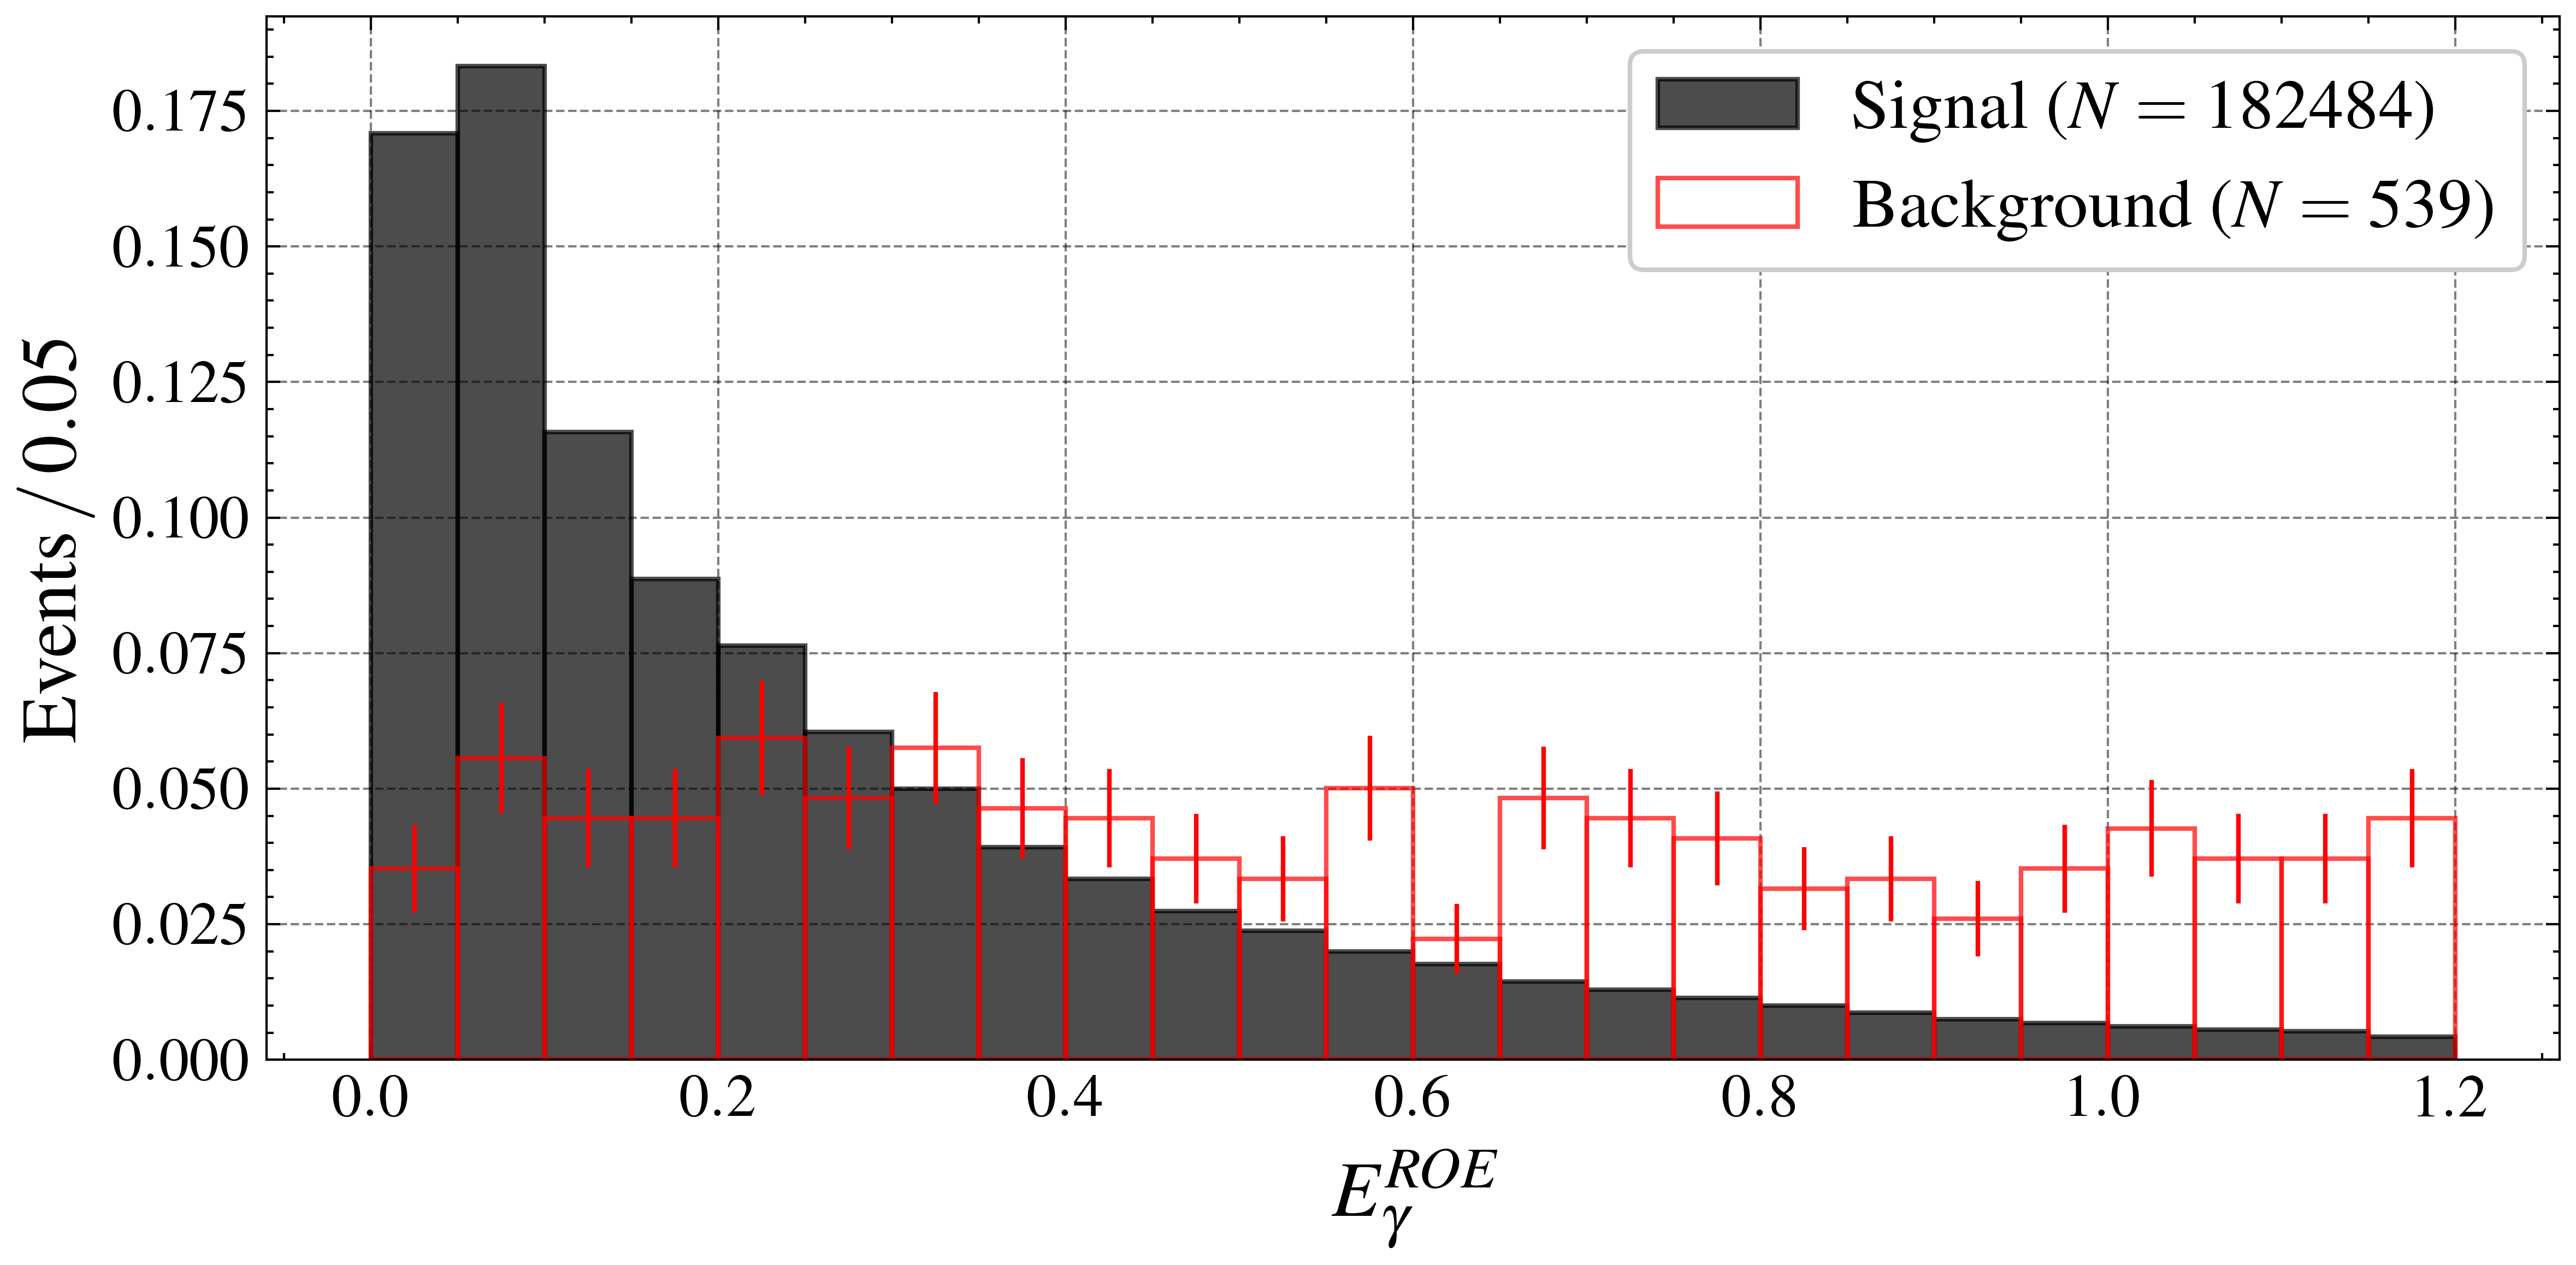

In [74]:
wbin = 0.05
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)//wbin +2))

fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))


bin_centers_sig, counts_sig, N_sig = compute_histogram(
    sig, bins, "E_gamma_in_ROE",
    filter_mask=(mask_lep & (pc.field("is0") == 1)),
    norm=True, nanto=-1
) 
ax.bar(
    bin_centers_sig, counts_sig,
    width=wbin, align='center',
    alpha=0.7, linewidth=1,
    edgecolor=colors[0], color=colors[0], ecolor=colors[0],
    label=f"Signal ($N = {N_sig}$)",
)

bin_centers_bsbs, counts_bsbs, N_bsbs = compute_histogram(
    bsbs, bins, "E_gamma_in_ROE",
    filter_mask=(mask_lep & (pc.field("is0") == 1)),
    norm=True, nanto=-1
) 
ax.bar(
    bin_centers_bsbs, counts_bsbs,
    yerr=np.sqrt(counts_bsbs)/np.sqrt(N_bsbs),
    width=wbin, align='center',
    fill = False, alpha = 0.7, linewidth=1,
    edgecolor=colors[1], color=colors[1], ecolor=colors[1],
    label=f"Background ($N = {N_bsbs}$)"
)

ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}$')
ax.set_xlabel(r'$E_{\gamma}^{ROE}$')
ax.legend()

plt.tight_layout()
plt.show()


In [75]:
from xgboost import XGBClassifier
import json

In [8]:
model = XGBClassifier()
model.load_model("bdt_model.json")
with open("columns_and_fom.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = data_to_save["FoM"]

In [76]:
v1 = get_values(bsbs, columns + ['E_gamma_in_ROE', 'M0'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1)))
v2 = get_values(nonbsbs, columns + ['E_gamma_in_ROE', 'M0'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1)))
v3 = get_values(uds, columns + ['E_gamma_in_ROE', 'M0'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1)))
v4 = get_values(uds, columns + ['E_gamma_in_ROE', 'M0'], filter_mask=(mask & mask_lep & (pc.field("is0") == 0)))
v5 = get_values(nonbsbs, columns + ['E_gamma_in_ROE', 'M0'], filter_mask=(mask & mask_lep & (pc.field("is0") == 0)))
v6 = get_values(bsbs, columns + ['E_gamma_in_ROE', 'M0'], filter_mask=(mask & mask_lep & (pc.field("is0") == 0)))
v1["marker"] = 1  # $B_S \to D(\ell \nu)\ell \nu$
v2["marker"] = 2  # nonbsbs
v3["marker"] = 3  # continuum
v4["marker"] = 4  # FEI missID
v5["marker"] = 5  # FEI missID
v6["marker"] = 6  # FEI missID

data = pd.concat([v1, v2, v3, v4, v5, v6], ignore_index=True)


Total data size: 0.02 MB
Total data size: 0.00 MB
Total data size: 0.00 MB
Total data size: 0.00 MB
Total data size: 0.00 MB
Total data size: 0.01 MB


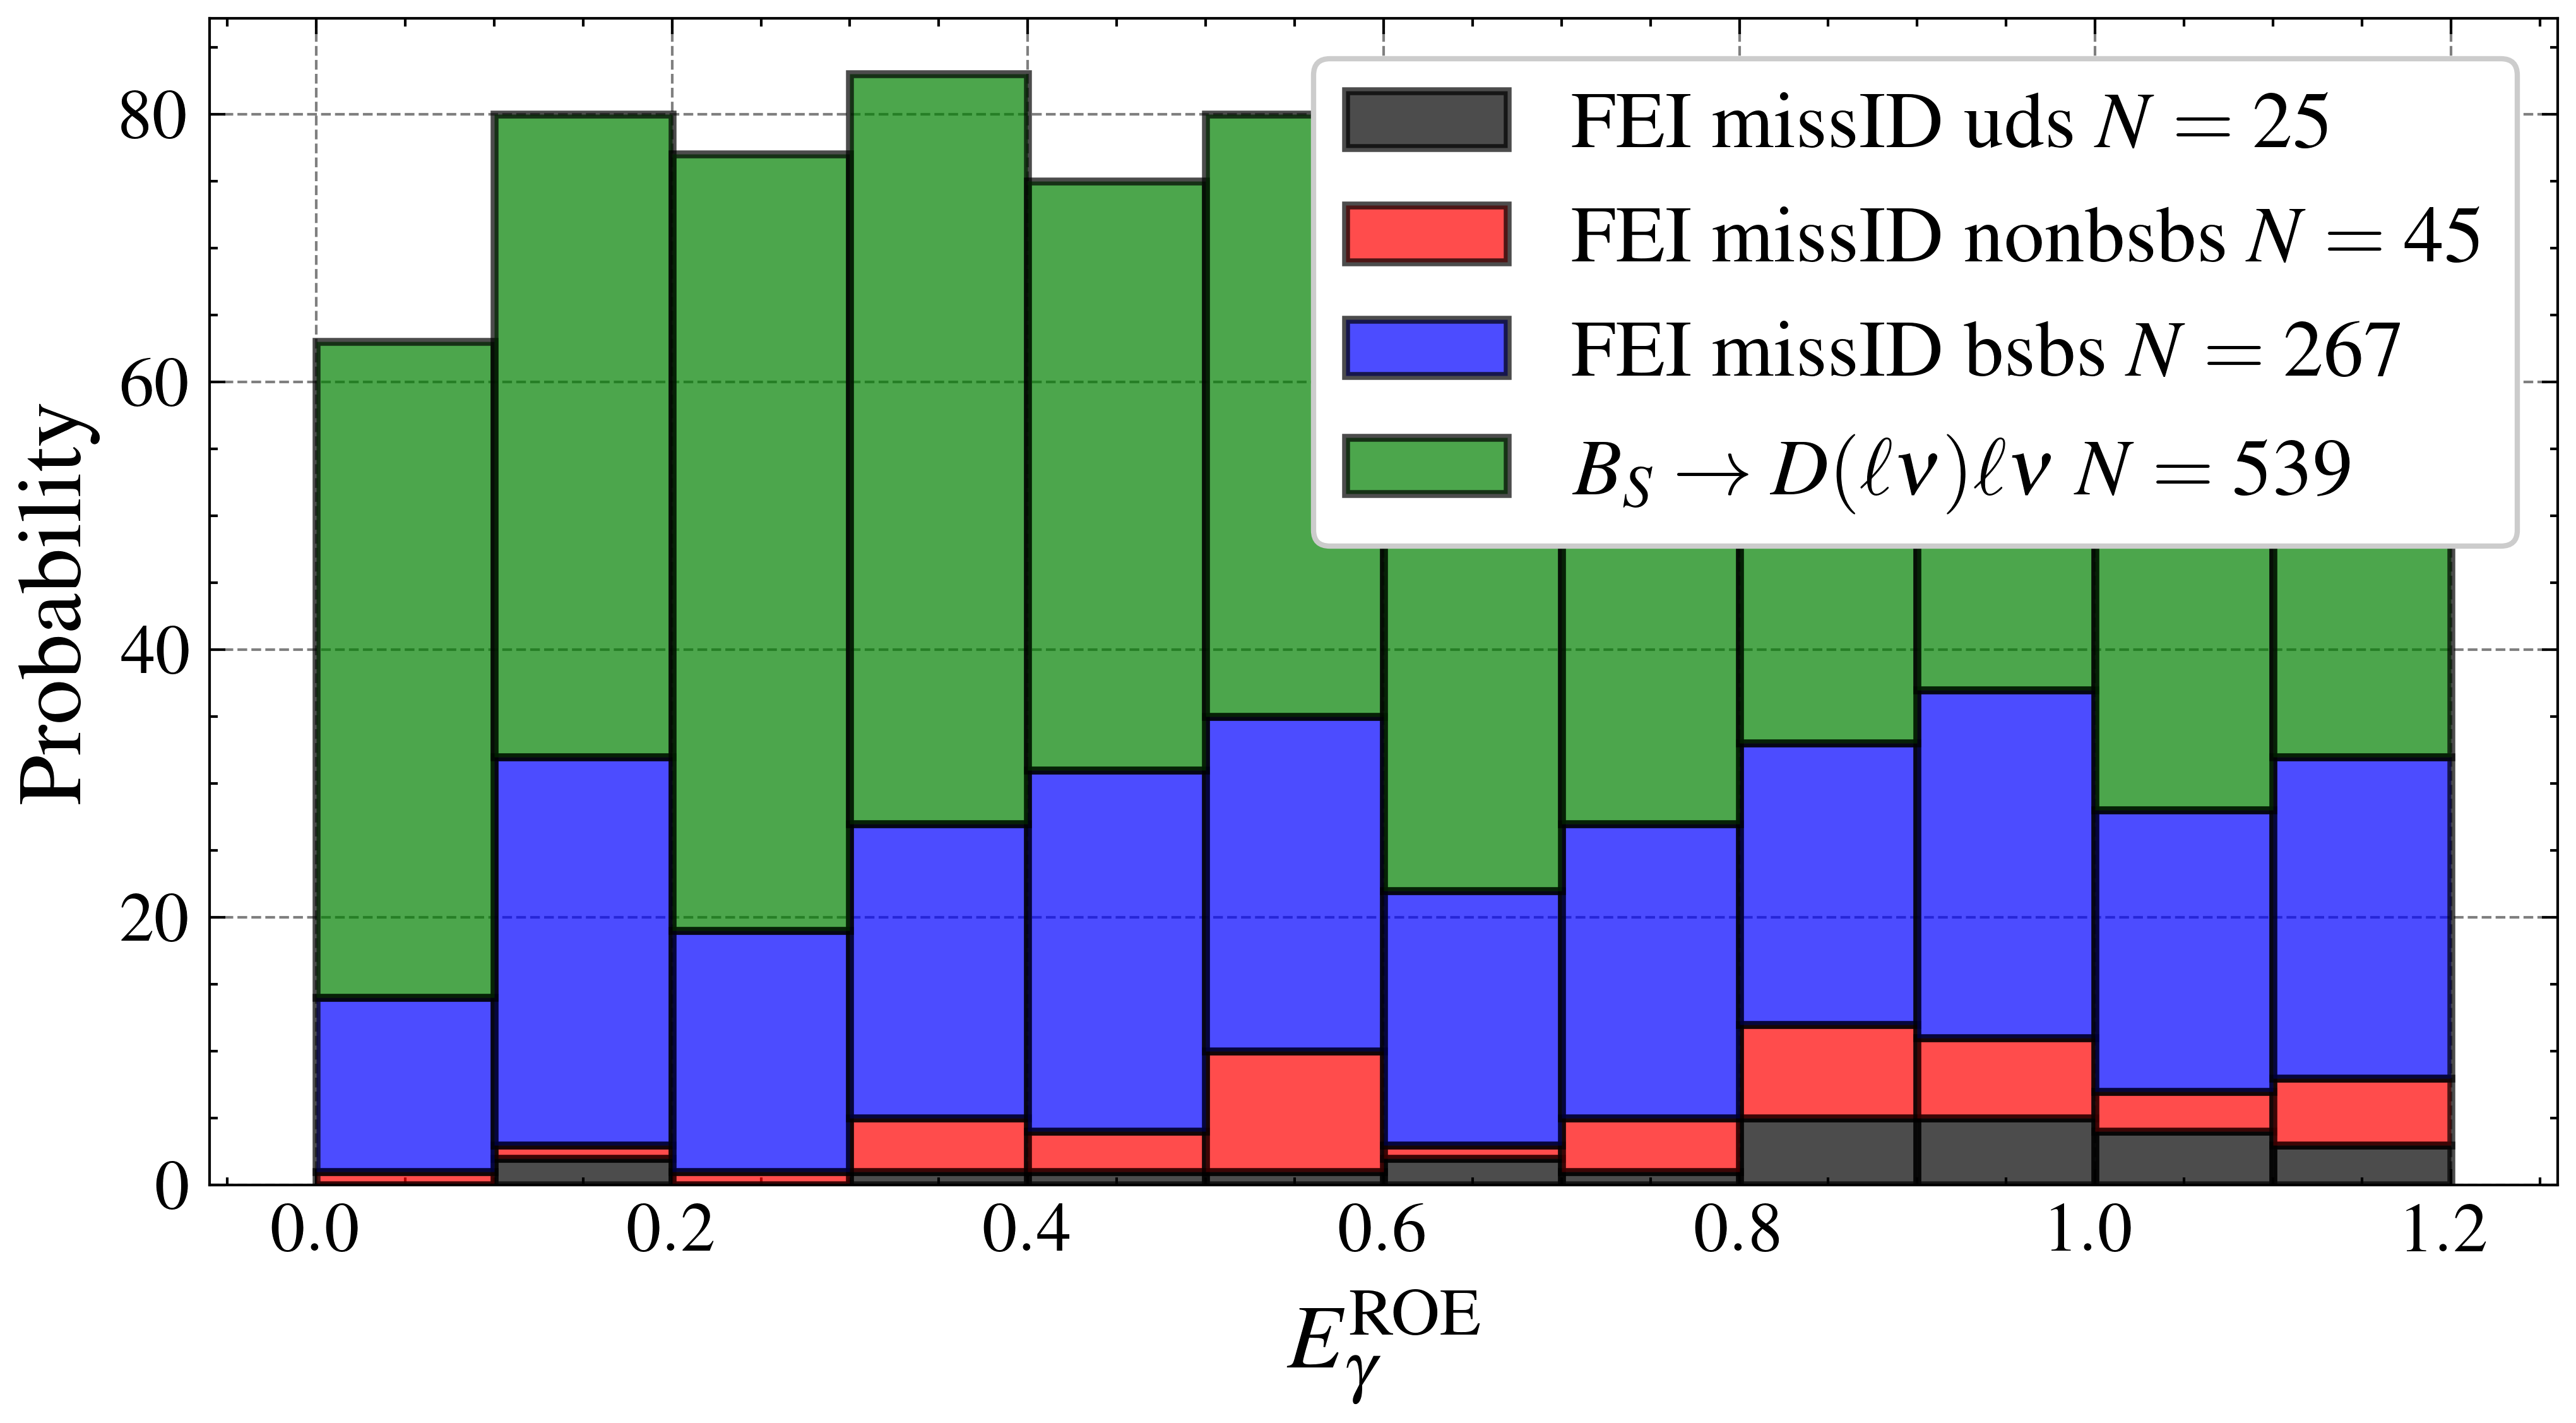

In [114]:
wbin = 0.1
a = 0
b = 1.2
bins = np.linspace(a, b, int((b - a) // wbin) + 2)

marker_labels = {
    1: r"$B_S \to D(\ell \nu)\ell \nu$",
    2: "nonbsbs",
    3: "Continuum",
    4: "FEI missID uds",
    5: "FEI missID nonbsbs",
    6: "FEI missID bsbs"
}

stack_data = []
stack_labels = []
for marker in sorted(data["marker"].unique(), key=lambda x: (data["marker"] == x).sum()):
    subset = data[data["marker"] == marker]["E_gamma_in_ROE"]
    stack_data.append(subset)
    stack_labels.append(f"{marker_labels[marker]} $N = {len(subset)}$")

# Рисуем
plt.hist(stack_data, bins=bins, stacked=True, alpha=0.7, edgecolor="black", linewidth=1.5, label=stack_labels)


plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
plt.ylabel("Probability")
plt.grid(True)
plt.legend()
plt.show()

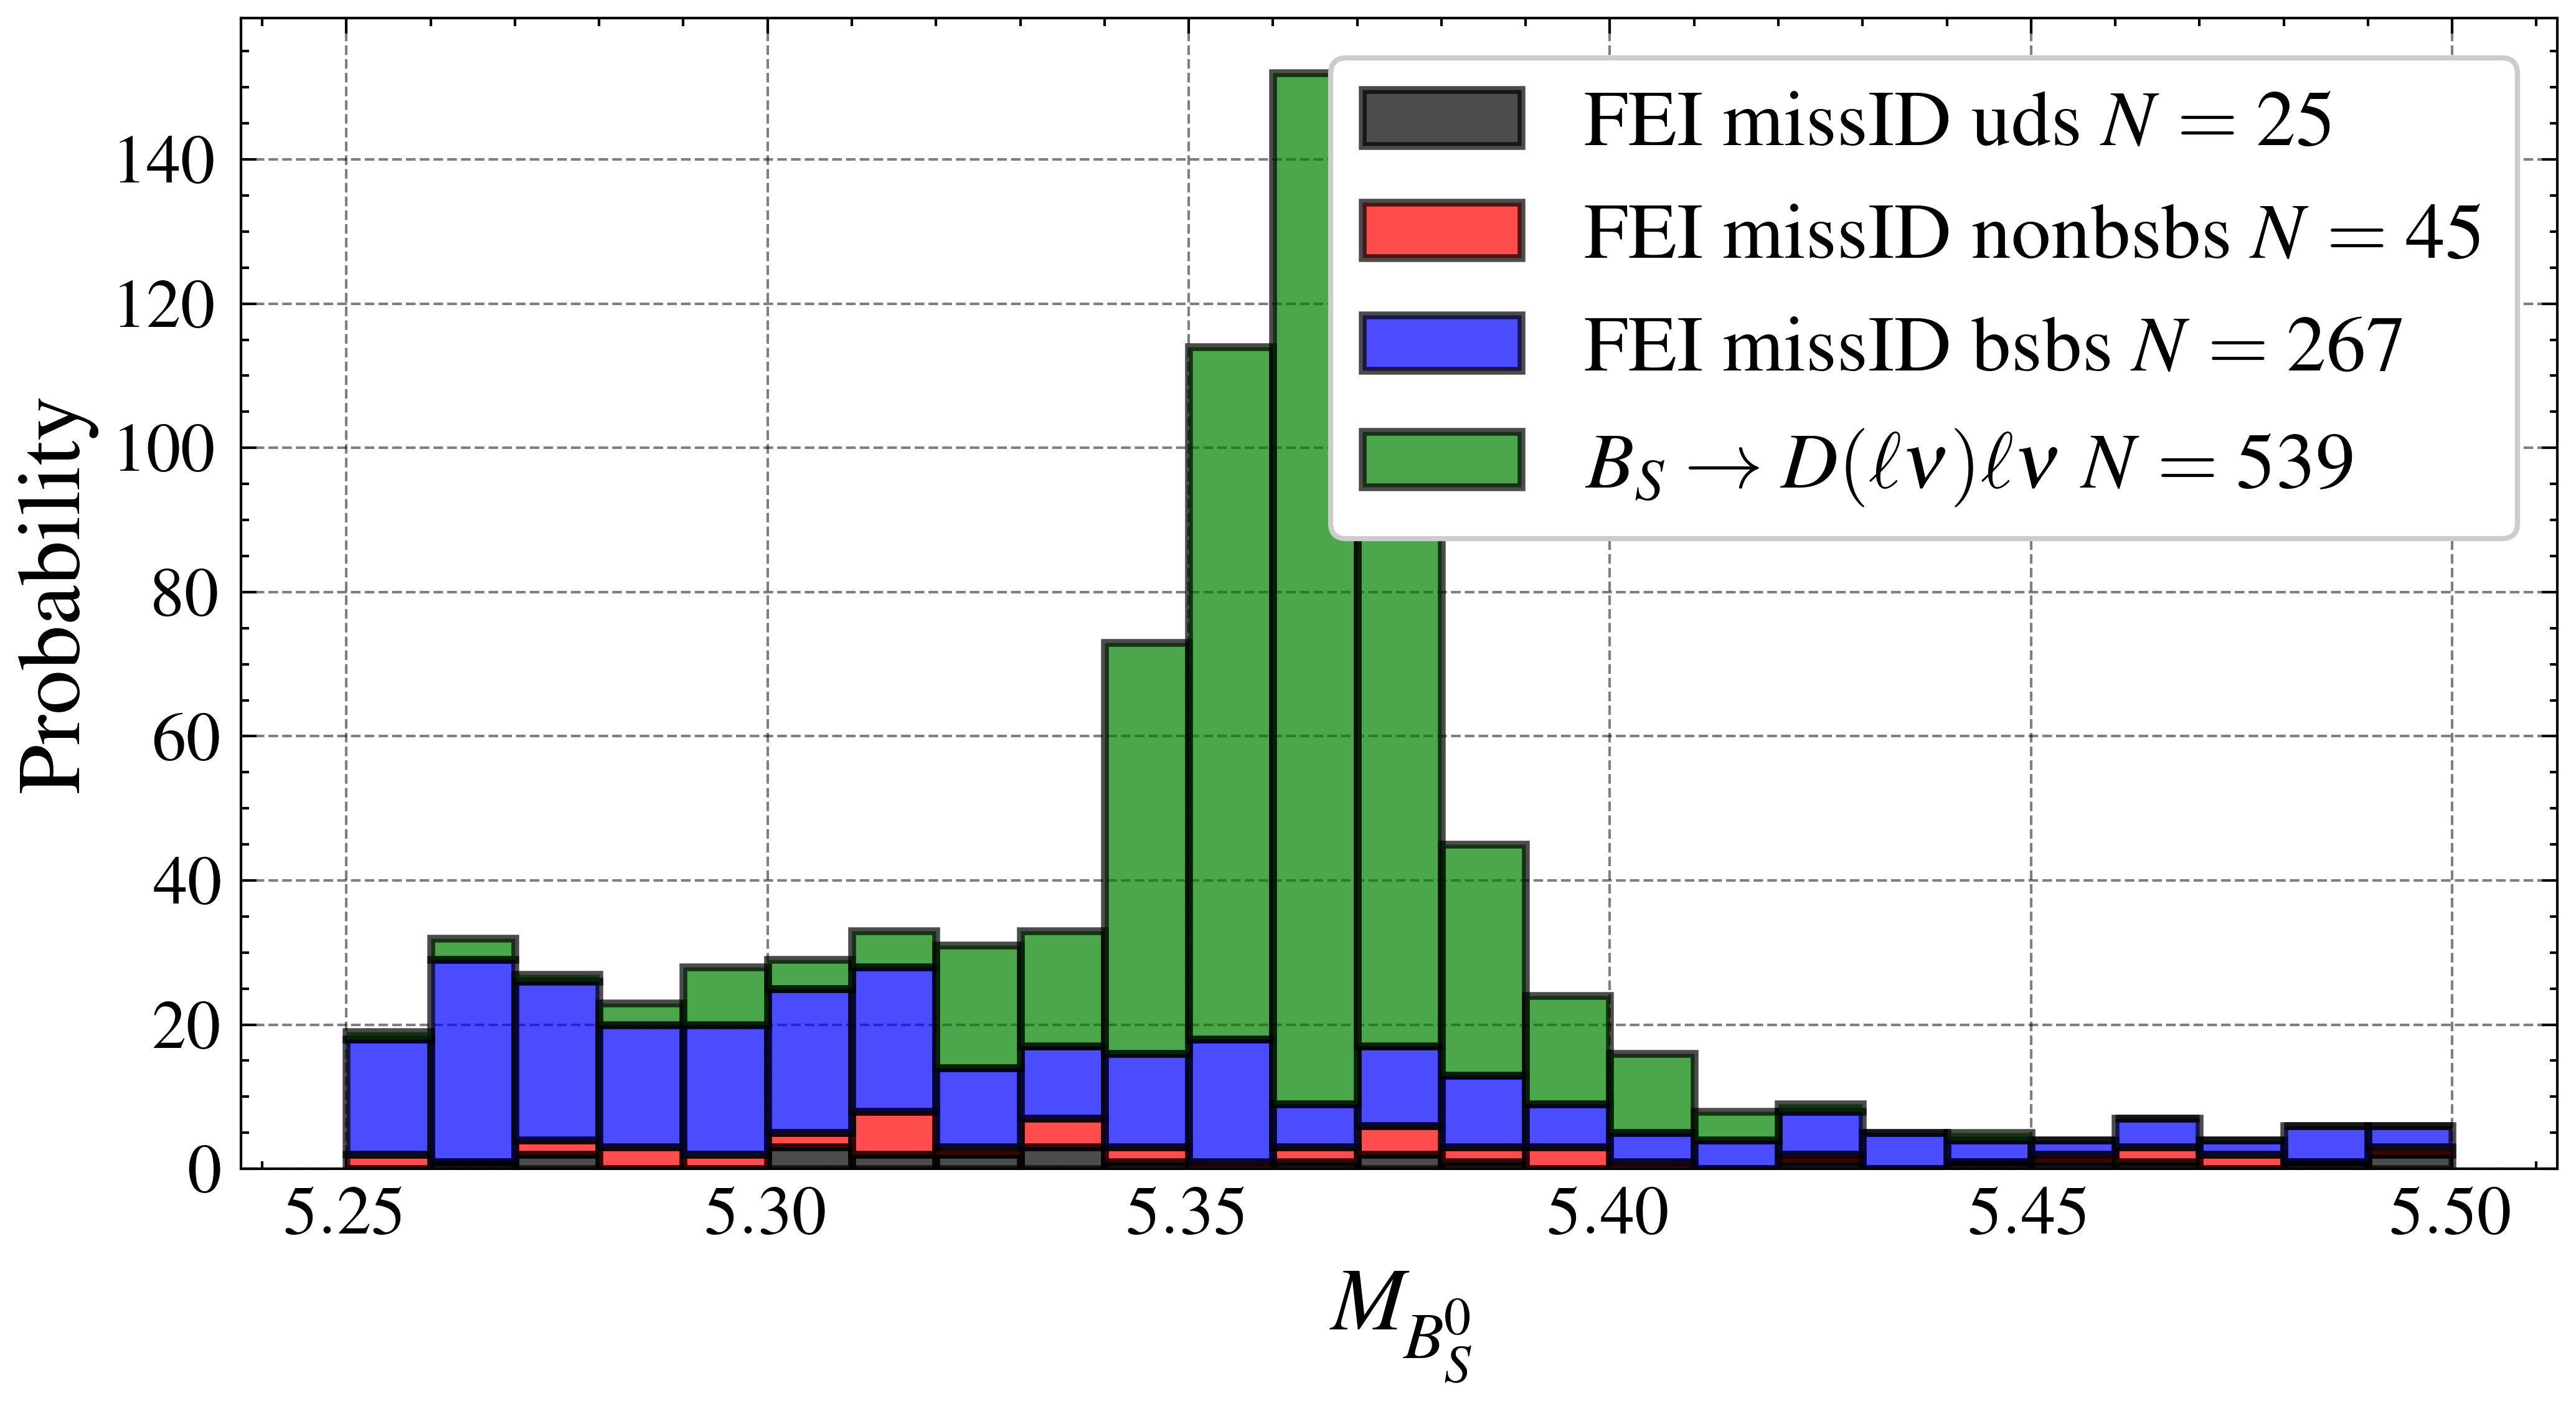

In [78]:
wbin = 0.01
a = 5.25
b = 5.5
bins = np.linspace(a, b, int((b - a) // wbin) + 2)

marker_labels = {
    1: r"$B_S \to D(\ell \nu)\ell \nu$",
    2: "nonbsbs",
    3: "Continuum",
    4: "FEI missID uds",
    5: "FEI missID nonbsbs",
    6: "FEI missID bsbs"
}

stack_data = []
stack_labels = []
for marker in sorted(data["marker"].unique(), key=lambda x: (data["marker"] == x).sum()):
    subset = data[data["marker"] == marker]["M0"]
    stack_data.append(subset)
    stack_labels.append(f"{marker_labels[marker]} $N = {len(subset)}$")

plt.hist(stack_data, bins=bins, stacked=True, alpha=0.7, edgecolor="black", linewidth=1.5, label=stack_labels)


plt.xlabel(r"$M_{B_S^0}$")
plt.ylabel("Probability")
plt.grid(True)
plt.legend()
plt.show()

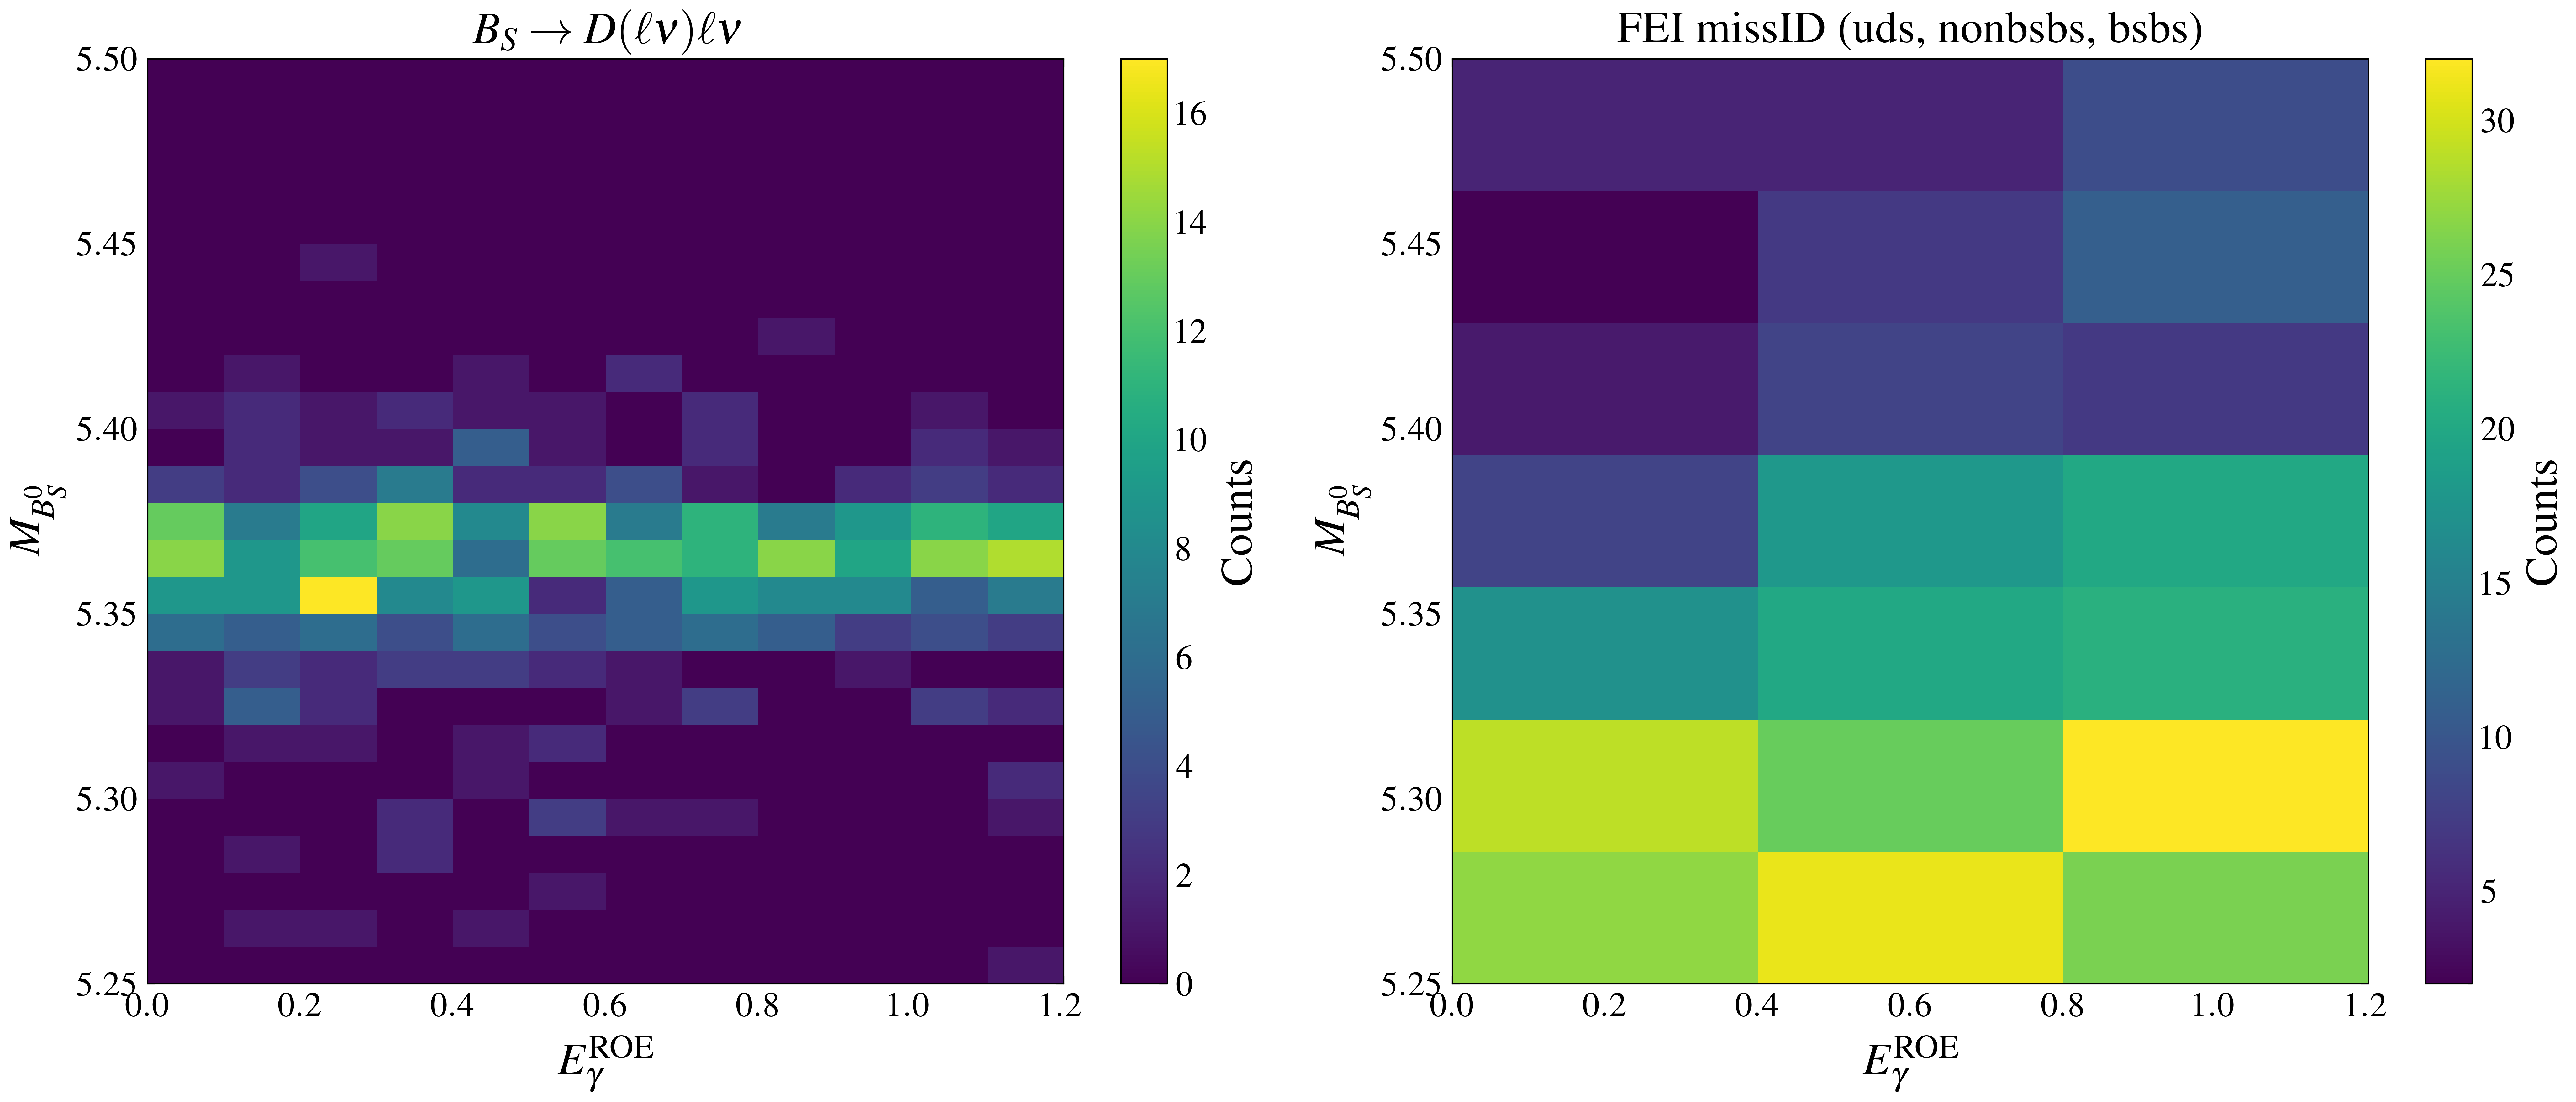

In [84]:

wbin_x, a_x, b_x = 0.1, 0, 1.2
wbin_y, a_y, b_y = 0.01, 5.25, 5.5

bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x) + 2)
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y) + 2)

signal_data = data[data["marker"] == 1]
fei_missid_data = data[data["marker"].isin([4, 5, 6])]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

h_sig = axs[0].hist2d(signal_data["E_gamma_in_ROE"], signal_data["M0"], 
                      bins=[bins_x, bins_y])
axs[0].set_xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
axs[0].set_ylabel(r"$M_{B_S^0}$")
axs[0].set_title(r"$B_S \to D(\ell \nu)\ell \nu$")
plt.colorbar(h_sig[3], ax=axs[0], label='Counts')

wbin_x, a_x, b_x = 0.1*4, 0, 1.2
wbin_y, a_y, b_y = 0.01*4, 5.25, 5.5
bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x) + 2)
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y) + 2)


h_fei = axs[1].hist2d(fei_missid_data["E_gamma_in_ROE"], fei_missid_data["M0"], 
                      bins=[bins_x, bins_y])
axs[1].set_xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
axs[1].set_ylabel(r"$M_{B_S^0}$")
axs[1].set_title("FEI missID (uds, nonbsbs, bsbs)")
plt.colorbar(h_fei[3], ax=axs[1], label='Counts')

plt.tight_layout()
plt.show()


In [ ]:

def get_pdf(data, a, b, num_points1=1000, num_points2=200):
    from scipy.interpolate import Akima1DInterpolator
    from scipy.integrate import quad

    data_sorted = np.sort(data[(data >= a) & (data <= b)])

    xs_cdf = np.linspace(a, b, num_points1)
    cdf = np.searchsorted(data_sorted, xs_cdf, side='right') / len(data_sorted)

    cdf_interp = Akima1DInterpolator(xs_cdf, cdf)

    xs_pdf = np.linspace(a, b, num_points2)
    dcdf = np.gradient(cdf_interp(xs_pdf), xs_pdf)
    pdf_vals = np.clip(dcdf, 0, None)
    dx = np.diff(xs_pdf)
    dx = np.append(dx, dx[-1])
    integral = np.sum(pdf_vals * dx)
    pdf_vals /= integral

    pdf_function_raw = Akima1DInterpolator(xs_pdf, pdf_vals)
    integral_func, _ = quad(pdf_function_raw, a, b, limit=200)
    pdf_function = lambda x: np.clip(pdf_function_raw(x), 0, None) / integral_func

    return xs_pdf, pdf_vals, pdf_function


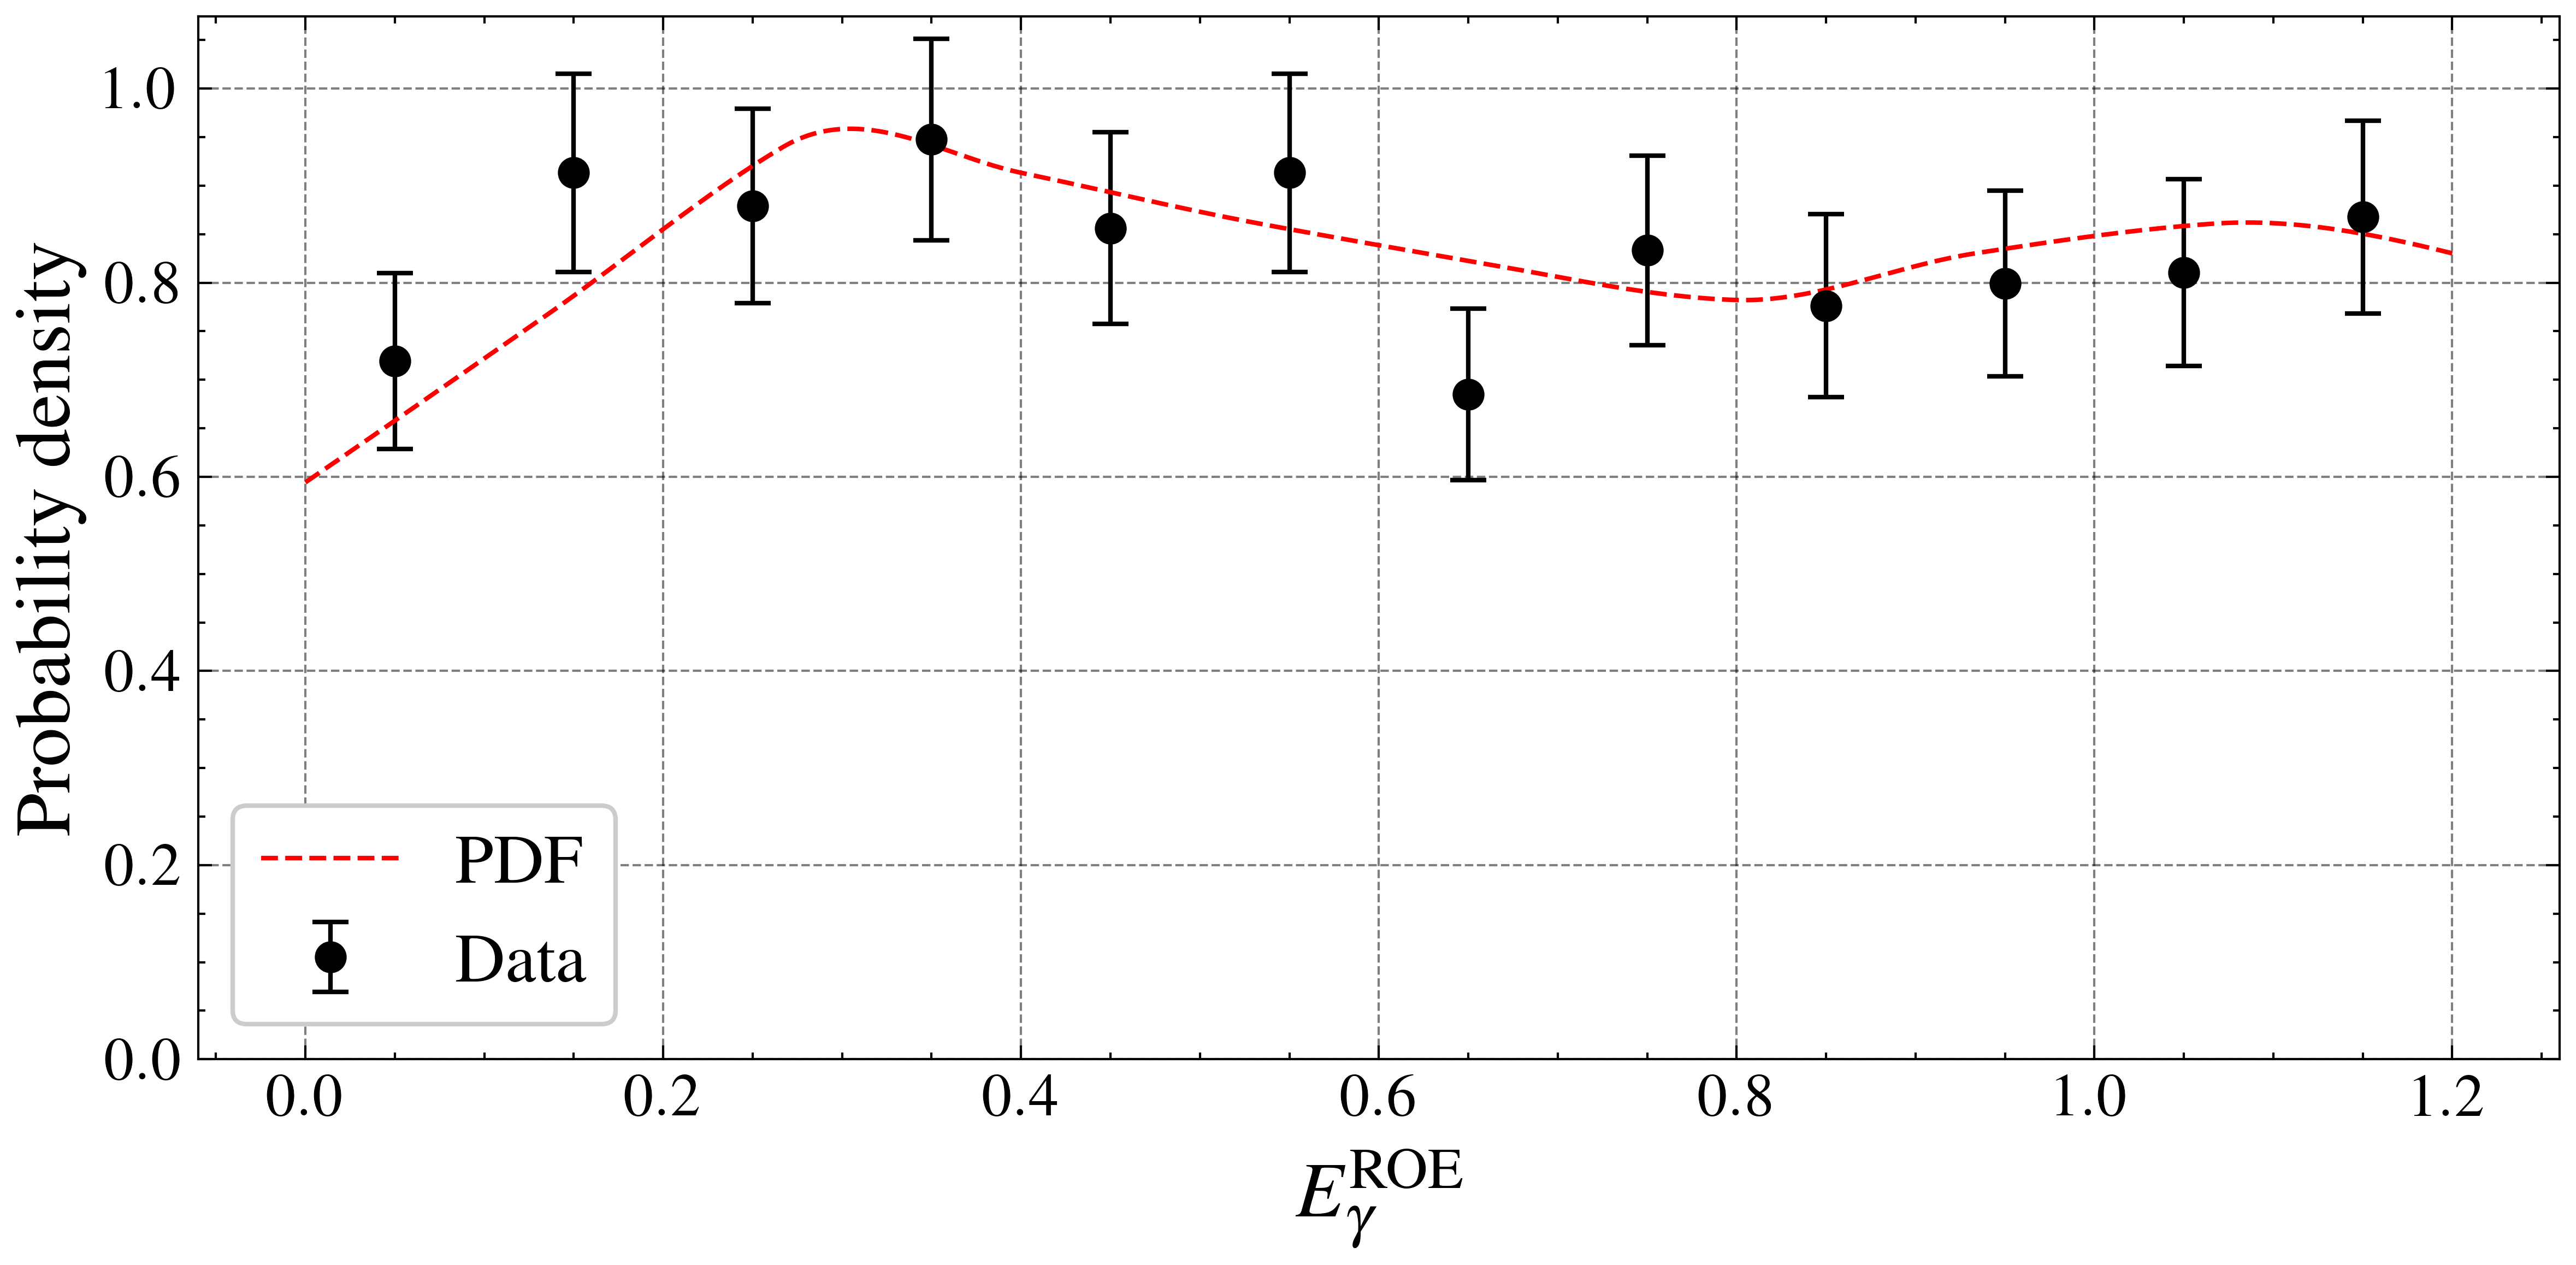

In [24]:

wbin = 0.1
a, b = 0, 1.2
bins = np.linspace(a, b, int((b - a) // wbin) + 2)

x_centers, pdf, dg_pdf = get_pdf(data["E_gamma_in_ROE"], a=a, b=b, num_points1=1000, num_points2=10)

all_values = data["E_gamma_in_ROE"]

fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

errorhist(all_values, bins=bins, err_func=np.sqrt, fmt='o', axs=ax, density=True, capsize=4, label="Data")

ax.plot(np.linspace(a, b, 1000), dg_pdf(np.linspace(a, b, 1000)), label="PDF")

ax.set_xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
ax.set_ylabel("Probability density")
ax.set_ylim(0)
ax.legend()
plt.tight_layout()
plt.show()


In [108]:
from scipy.interpolate import RectBivariateSpline
import numpy as np

def get_2d_pdf(data_x, data_y, a_x, b_x, a_y, b_y,
               num_cdf_x=100, num_cdf_y=100,
               num_pdf_x=10, num_pdf_y=10):
    """
    Вычисляет двумерную PDF как смешанную производную от CDF.

    :param data_x: массив значений по x
    :param data_y: массив значений по y
    :param [a_x, b_x], [a_y, b_y]: границы области
    :param num_cdf_x: количество точек CDF по x (гладкая интерполяция)
    :param num_cdf_y: количество точек CDF по y
    :param num_pdf_x: количество точек PDF по x (производная)
    :param num_pdf_y: количество точек PDF по y
    :return: сетки x_pdf, y_pdf и значения PDF на сетке
    """
    # Фильтрация данных по границам
    mask = (data_x >= a_x) & (data_x <= b_x) & (data_y >= a_y) & (data_y <= b_y)
    data_x = data_x[mask]
    data_y = data_y[mask]
    N = len(data_x)
    if N == 0:
        raise ValueError("No data within specified bounds.")

    # Сетки для CDF
    x_cdf = np.linspace(a_x, b_x, num_cdf_x)
    y_cdf = np.linspace(a_y, b_y, num_cdf_y)
    X_cdf, Y_cdf = np.meshgrid(x_cdf, y_cdf, indexing='ij')

    # Эмпирическая CDF
    cdf_grid = np.zeros_like(X_cdf)
    for i in range(num_cdf_x):
        for j in range(num_cdf_y):
            cdf_grid[i, j] = np.sum((data_x <= x_cdf[i]) & (data_y <= y_cdf[j])) / N

    # Интерполяция CDF
    cdf_interp = RectBivariateSpline(x_cdf, y_cdf, cdf_grid)

    # Сетка для PDF (может быть другой плотности)
    x_pdf = np.linspace(a_x, b_x, num_pdf_x)
    y_pdf = np.linspace(a_y, b_y, num_pdf_y)
    X_pdf, Y_pdf = np.meshgrid(x_pdf, y_pdf, indexing='ij')

    # Производная второго порядка — смешанная
    pdf_vals = np.zeros_like(X_pdf)
    for i in range(num_pdf_x):
        for j in range(num_pdf_y):
            pdf_vals[i, j] = cdf_interp.ev(x_pdf[i], y_pdf[j], dx=1, dy=1)

    # Обрезаем отрицательные артефакты
    pdf_vals = np.clip(pdf_vals, 0, None)

    # Нормировка
    dx = (b_x - a_x) / (num_pdf_x - 1)
    dy = (b_y - a_y) / (num_pdf_y - 1)
    integral = np.sum(pdf_vals) * dx * dy
    pdf_vals /= integral

    return x_pdf, y_pdf, pdf_vals


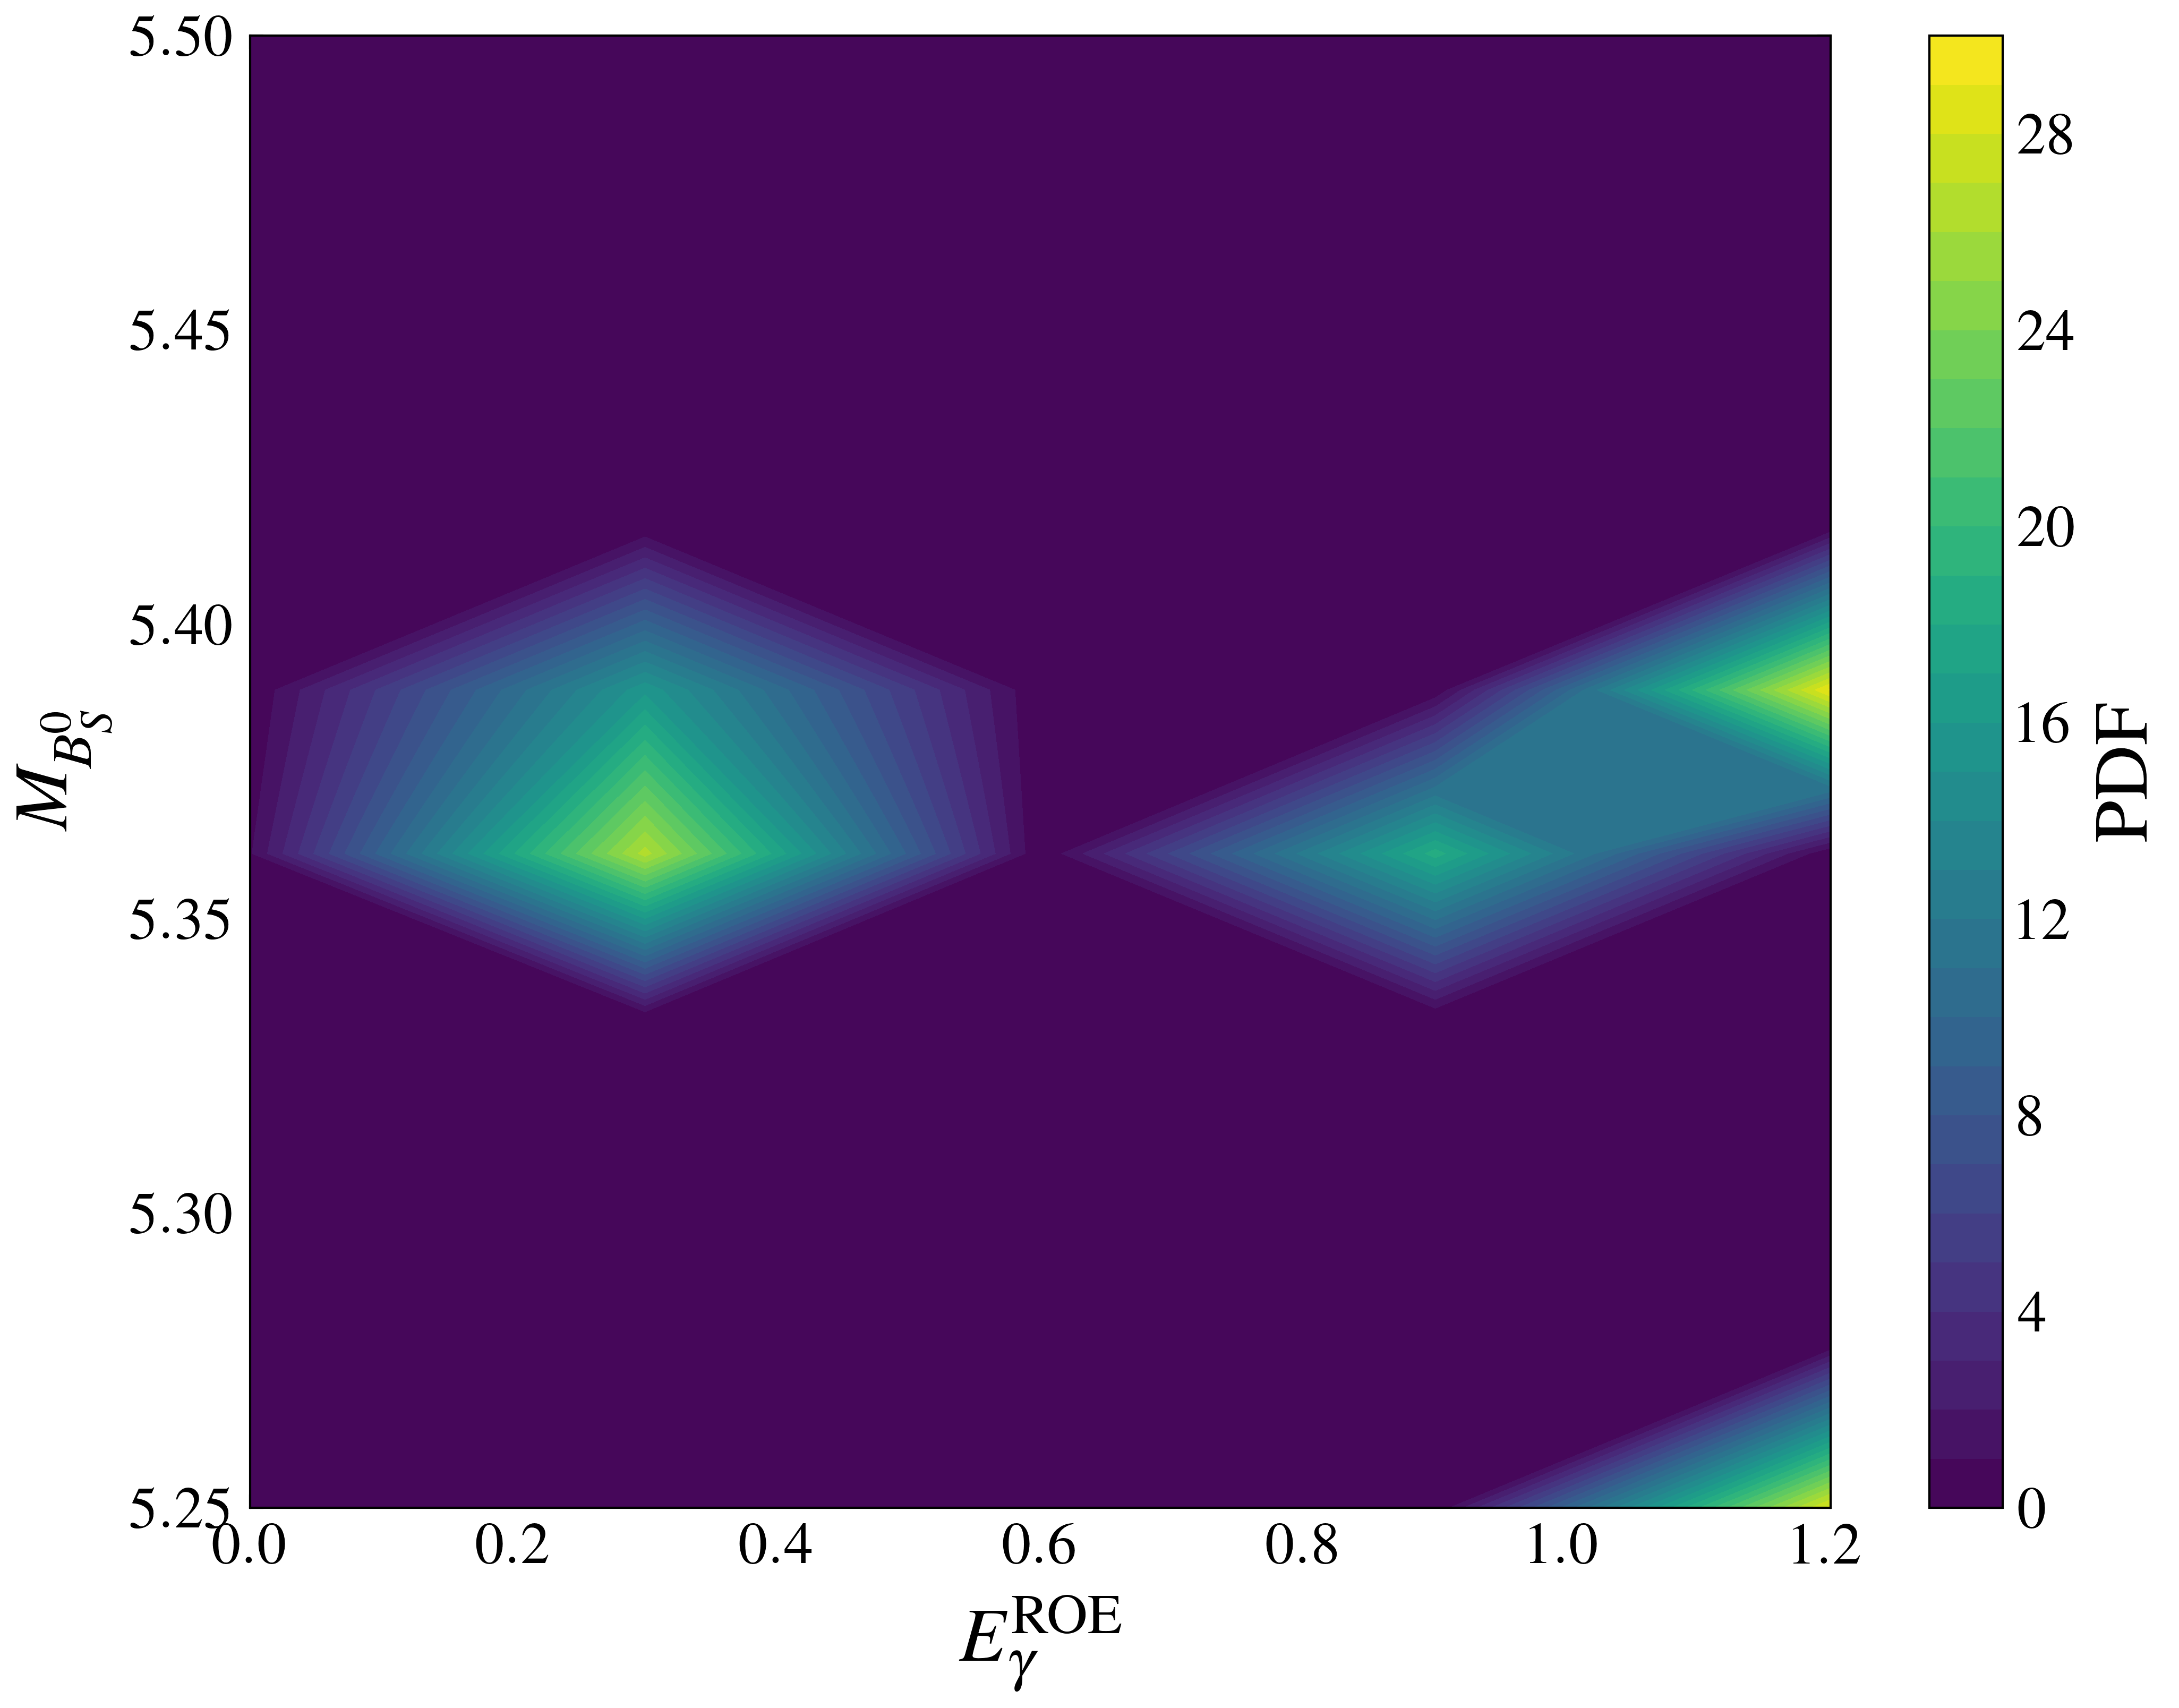

In [111]:
x, y, pdf = get_2d_pdf(signal_data["E_gamma_in_ROE"].values,
                       signal_data["M0"].values,
                       a_x, b_x, a_y, b_y,
                       num_cdf_x=100, num_cdf_y=100,
                        num_pdf_x=5, num_pdf_y=10)

plt.figure(figsize=(8,6))
plt.contourf(x, y, pdf.T, levels=30)
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
plt.ylabel(r"$M_{B_S^0}$")
plt.colorbar(label="PDF")

In [17]:
X_new = data[columns]

bdt_scores = model.predict_proba(X_new)[:, 1] 

data["bdt_score"] = bdt_scores

selected_mask = data["bdt_score"] > FoM

selected_data = data[selected_mask]


In [26]:
N_bg = len(data["E_gamma_in_ROE"])

In [27]:
def gen_toy(pdf_func, a, b, size=10000):
    samples = []
    ymax  = np.max(pdf_func(np.linspace(a, b, 1000)))
    while len(samples) < size:
        x_trial = np.random.uniform(a, b)
        y_trial = np.random.uniform(0, ymax)
        try:
            if y_trial <= pdf_func(x_trial):
                samples.append(x_trial)
        except: continue
    return np.array(samples)


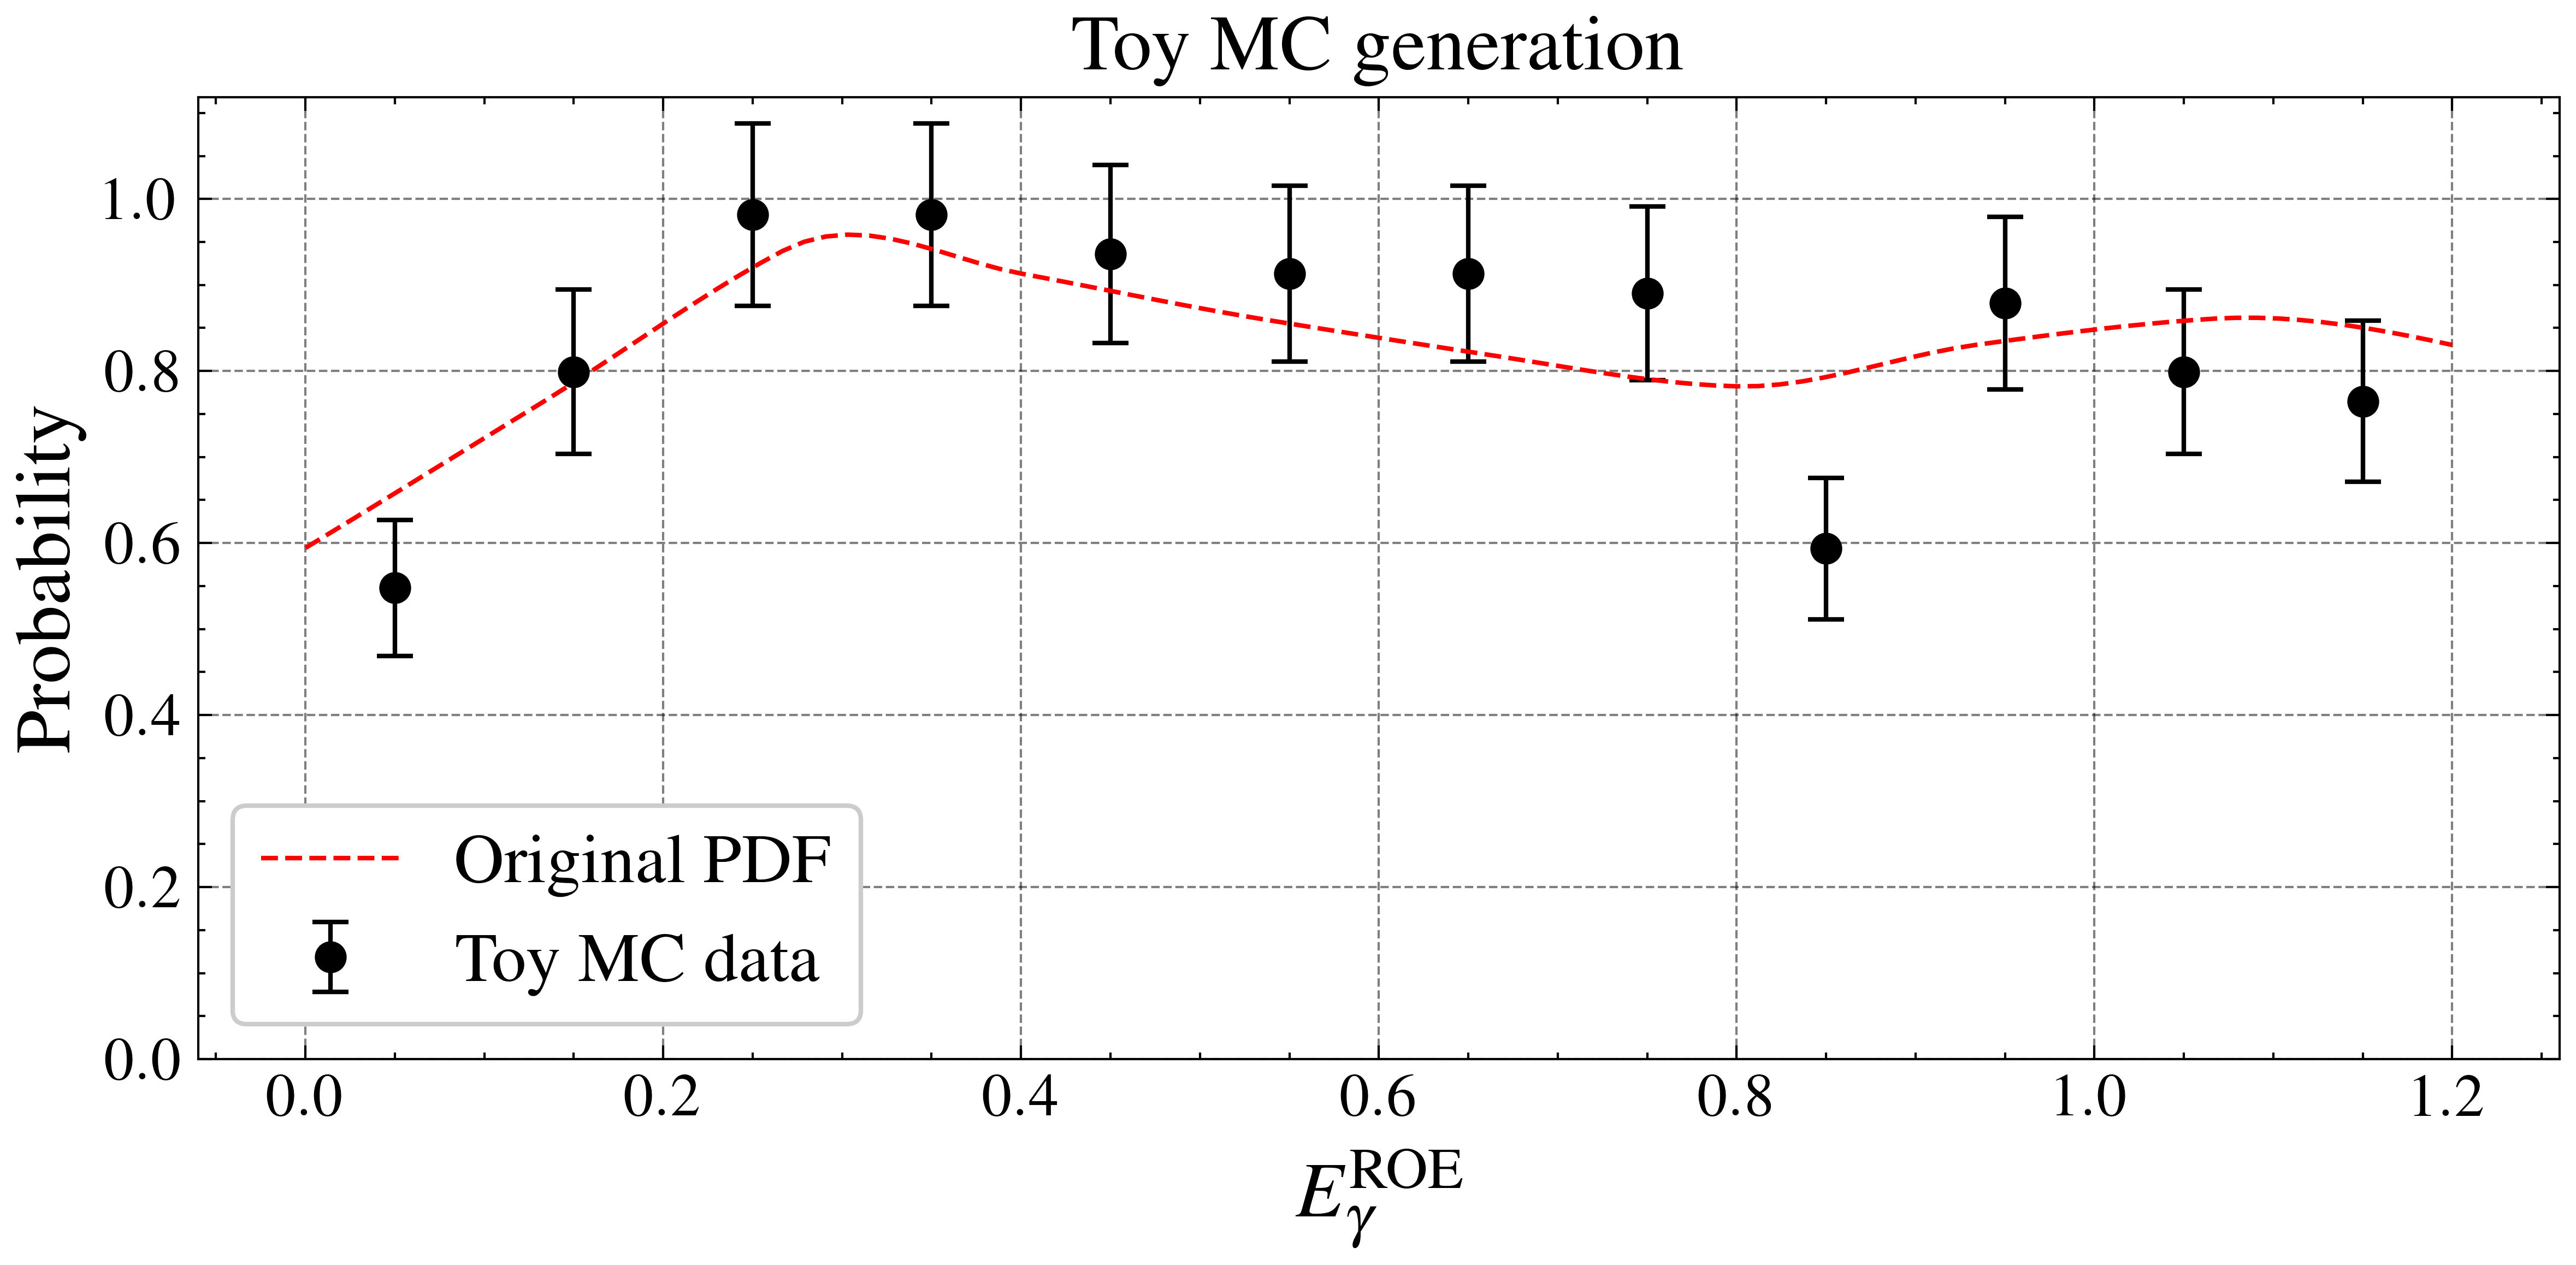

In [28]:
wbin = 0.1
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)//wbin + 2))

all_values = gen_toy(dg_pdf, a, b, N_bg)


errorhist(all_values, bins=bins, err_func=np.sqrt, fmt='o', density=True, capsize=4, label="Toy MC data")

plt.plot(np.linspace(a, b, 100), dg_pdf(np.linspace(a, b, 100)), label="Original PDF")
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
plt.ylabel("Probability")
plt.title("Toy MC generation")
plt.legend()
plt.ylim(0)
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
def f_E_g_lep_gamma(x, *, lam, k, theta):
    from scipy.special import gamma
    x = np.where(x <= 0.000001, 0.0001, x)
    x = x*lam
    base = (1 / (gamma(k) * theta**k)) * x**(k - 1) * np.exp(-x / theta)
    return base
with open("sig_fit.json", "r") as f:
    rez0 = dict(json.load(f))
    del rez0["norm"]

In [112]:
rez0

{'k': 0.7801691897883768,
 'theta': 2.8674669657459124,
 'lam': 9.666294071418994}

In [61]:
def max_lik(f, x, args0, a=0, b=0, bounds=None, err_need=False):
    if a == b:
        def df(*args):
            current_args = {k: v for k, v in zip(args0.keys(), args)}
            return -2*np.sum(np.log(f(x, **current_args)))
    else:
        def df(*args):
            current_args = {k: v for k, v in zip(args0.keys(), args)}
            return np.trapz(f(np.linspace(a, b, 1000), **current_args), np.linspace(a, b, 1000))-np.sum(np.log(f(x, **current_args)))

    from iminuit import Minuit
    minuit = Minuit(df, *[args0[k] for k in args0], name=list(args0.keys()))

    if bounds:
        for k, bnd in bounds.items():
            minuit.limits[k] = bnd

    minuit.migrad()

    rez = minuit.values.to_dict()
    errs = minuit.errors.to_dict() if err_need else None


    if err_need:
        return rez, errs
    return rez


In [64]:
f_fit = lambda x, *, A, B: f_E_g_lep_gamma(x, **rez0)/np.trapz(f_E_g_lep_gamma(np.linspace(0, 1.2, 1000), **rez0), np.linspace(0, 1.2, 1000)) * np.abs(A) + dg_pdf(x) * np.abs(B) 

C:\Users\matve\AppData\Local\Temp\ipykernel_10948\2194451270.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_fit = lambda x, *, A, B: f_E_g_lep_gamma(x, **rez0)/np.trapz(f_E_g_lep_gamma(np.linspace(0, 1.2, 1000), **rez0), np.linspace(0, 1.2, 1000)) * np.abs(A) + dg_pdf(x) * np.abs(B)
C:\Users\matve\AppData\Local\Temp\ipykernel_10948\4189690295.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(f(np.linspace(a, b, 1000), **current_args), np.linspace(a, b, 1000))-np.sum(np.log(f(x, **current_args)))


{'A': 12.027575300827891, 'B': 159.06560825515808}
{'A': 124.45163212382732, 'B': 161.58458306908187}
{'A': 80.74135916759705, 'B': 138.2513894470553}
{'A': 86.57780740228411, 'B': 160.41829936632948}
{'A': 19.0635276168326, 'B': 157.97028765750363}


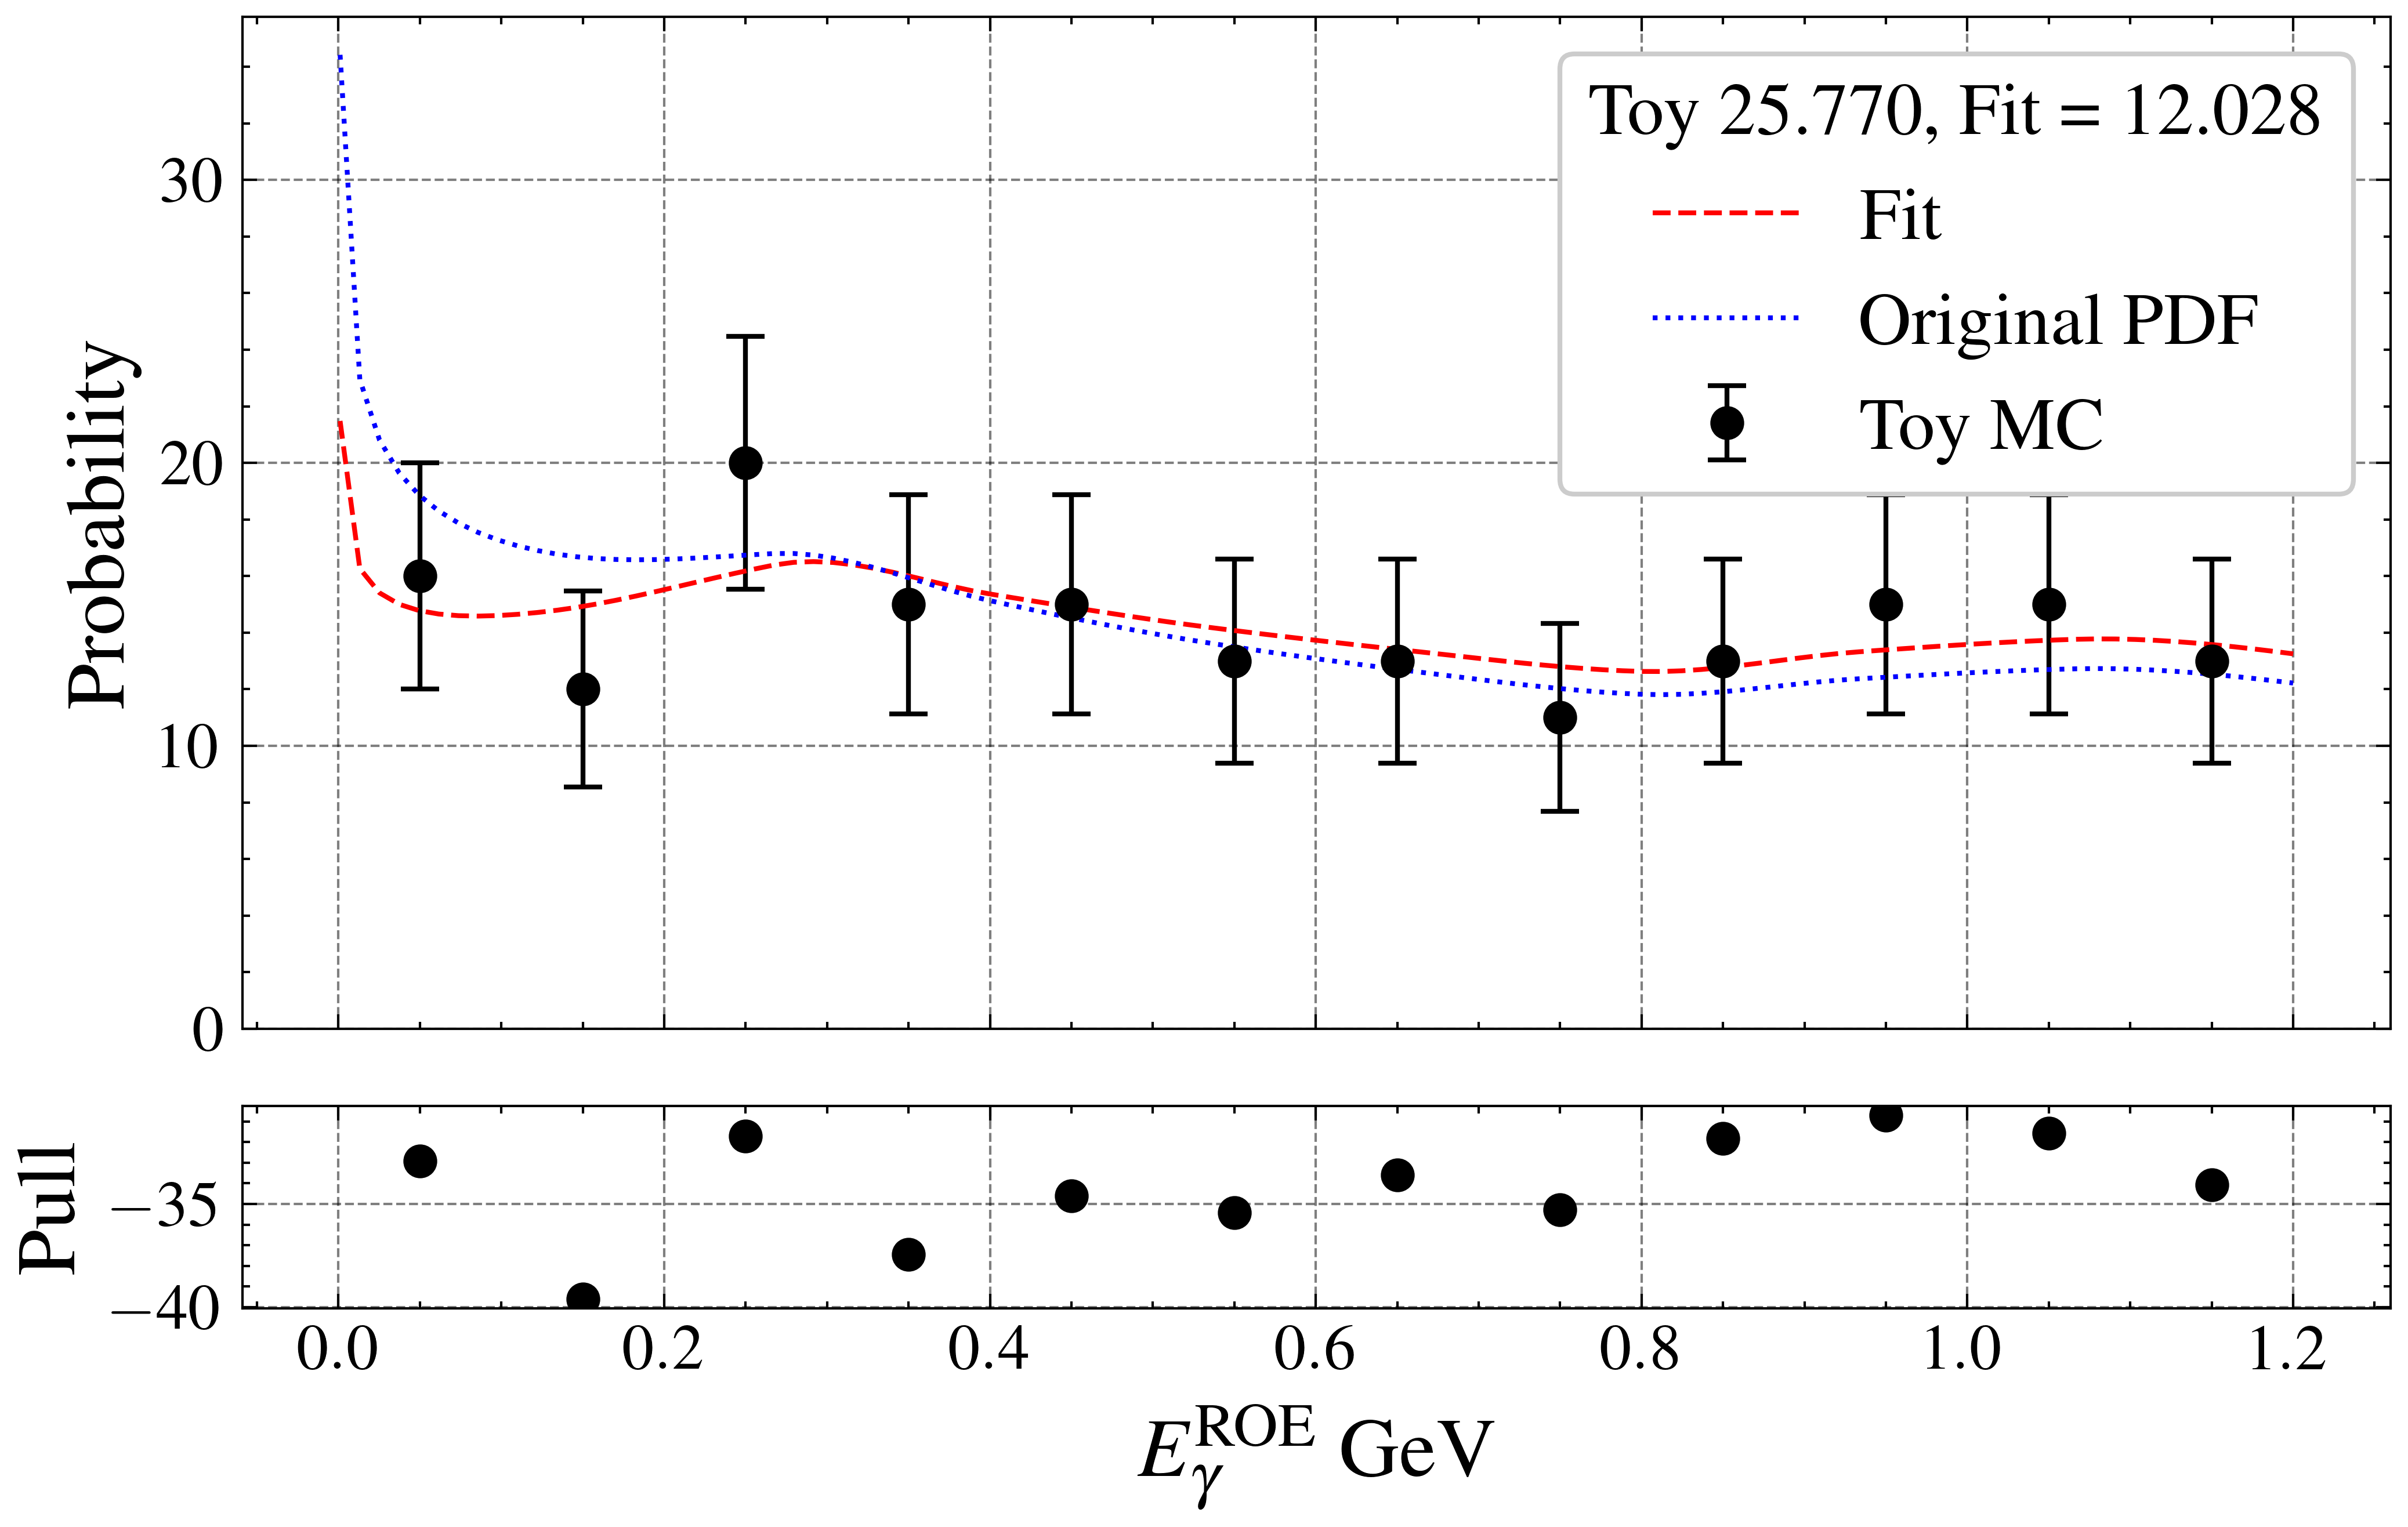

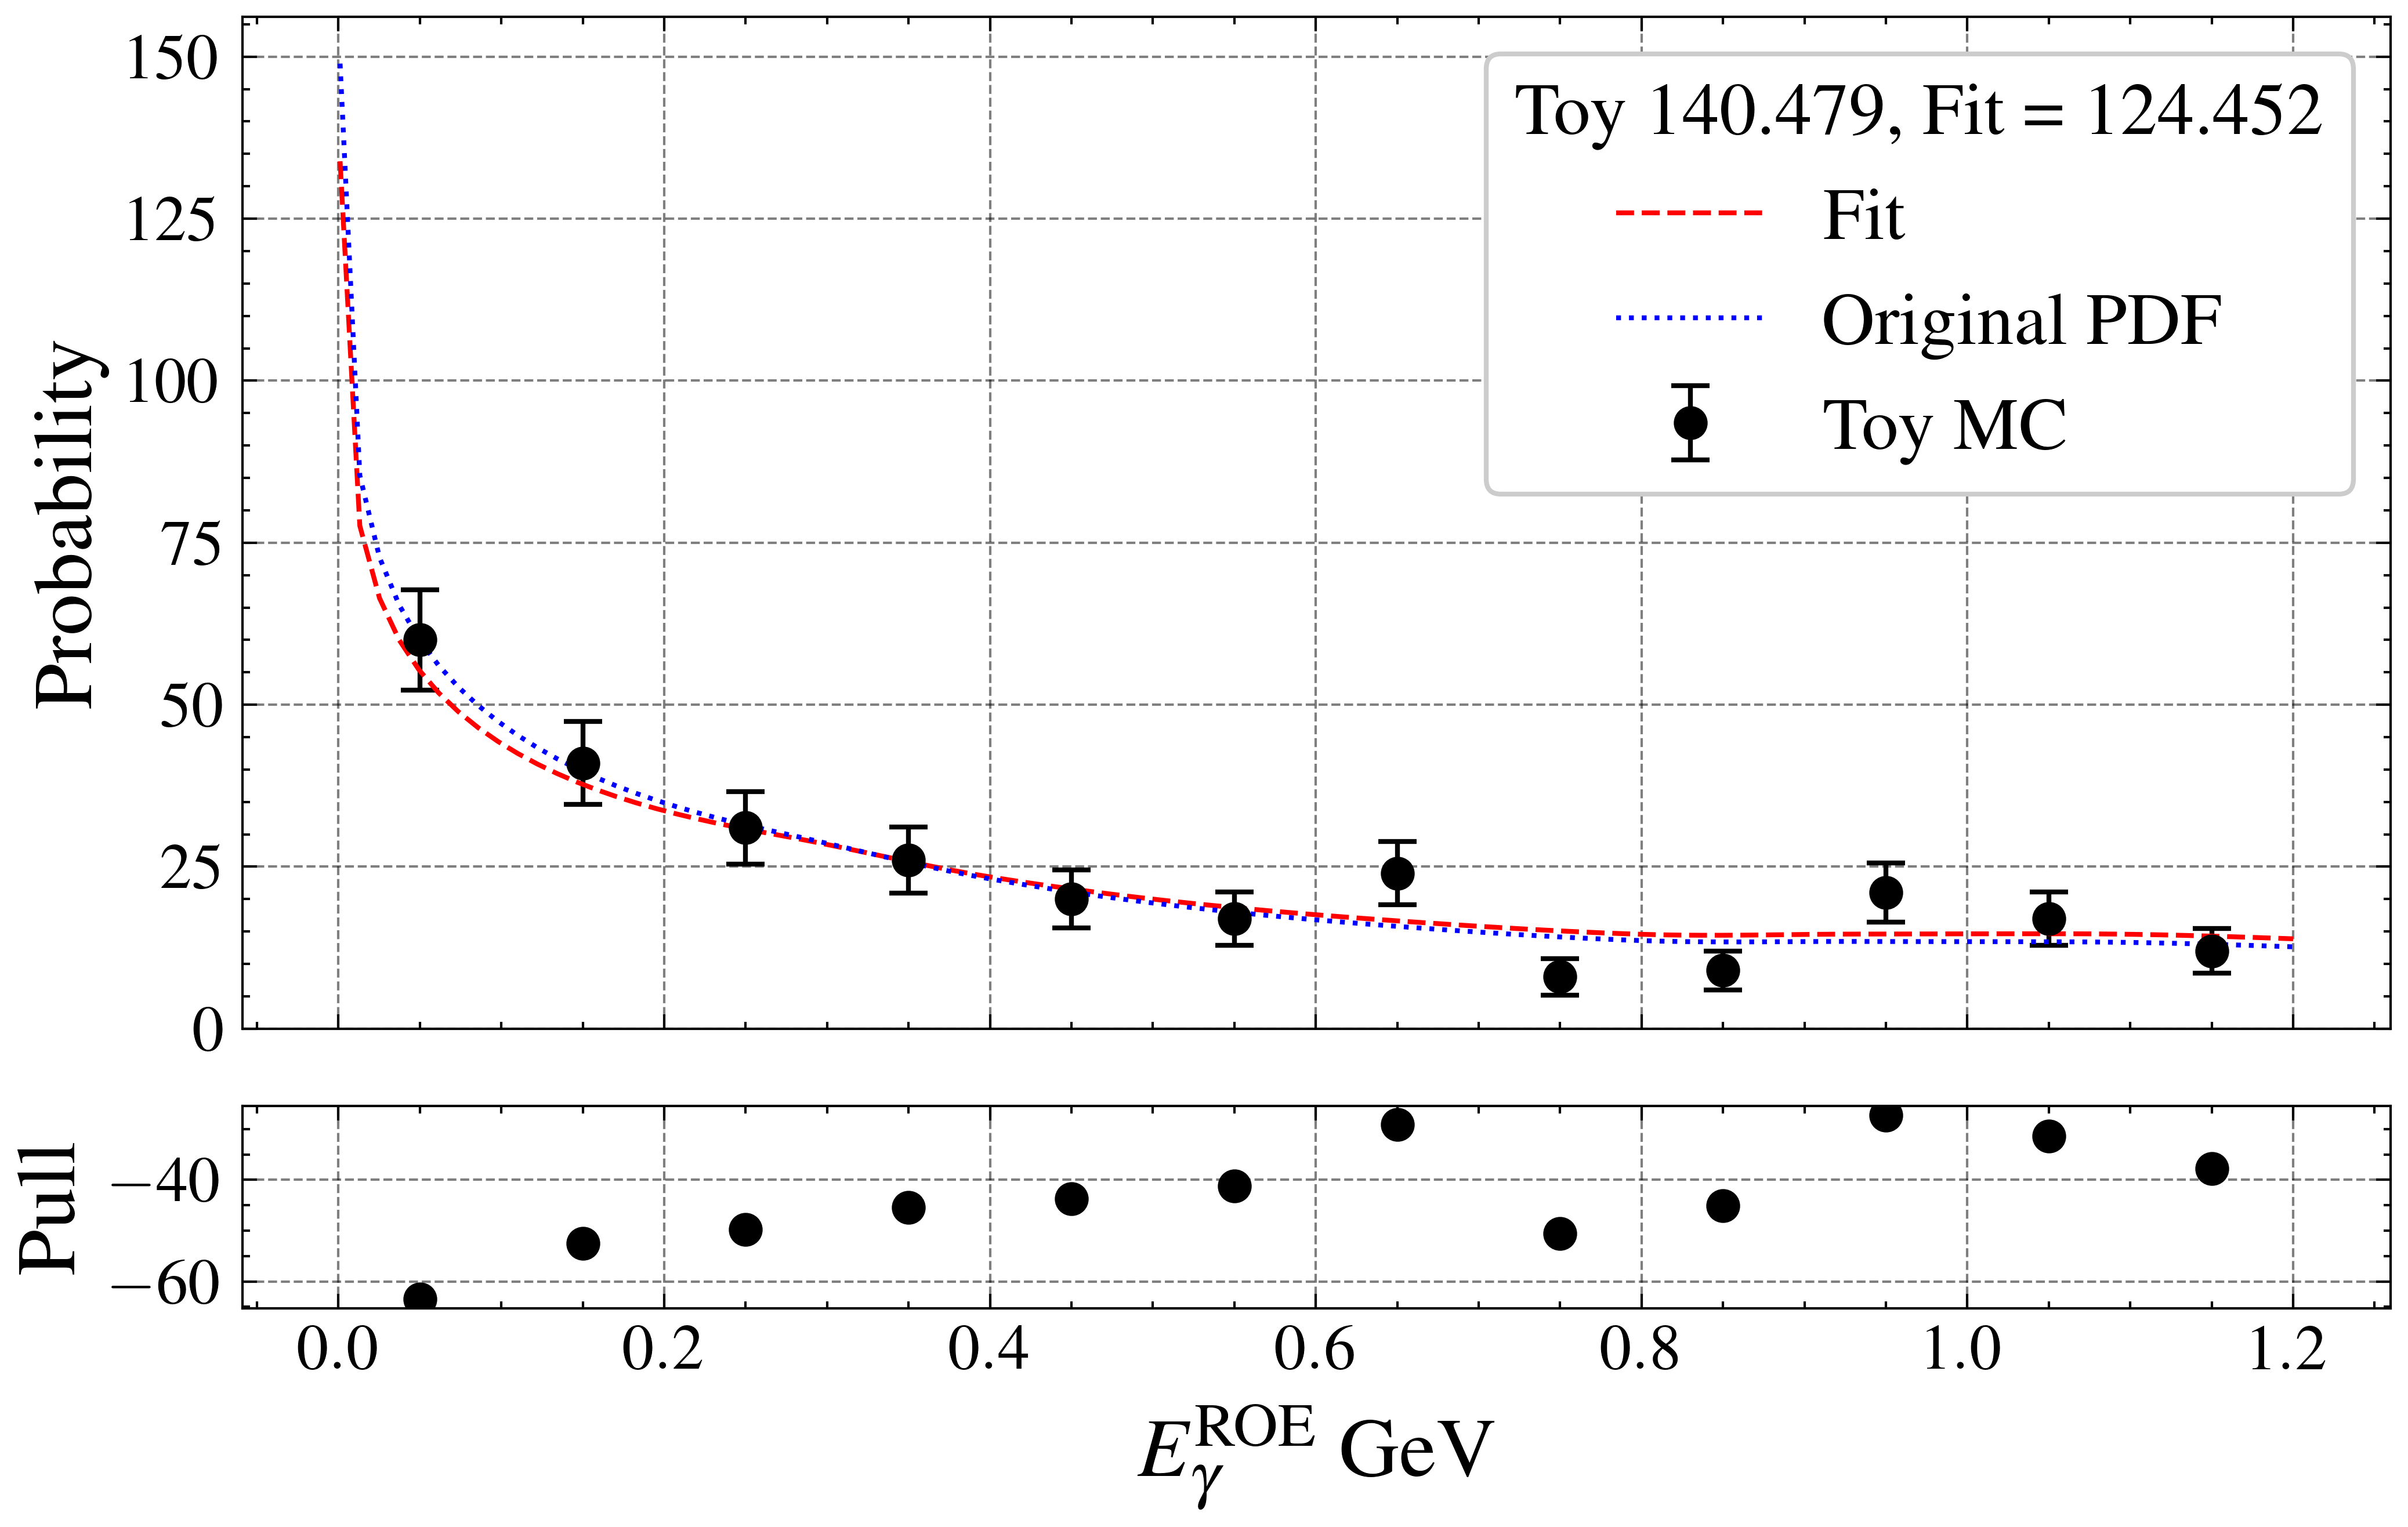

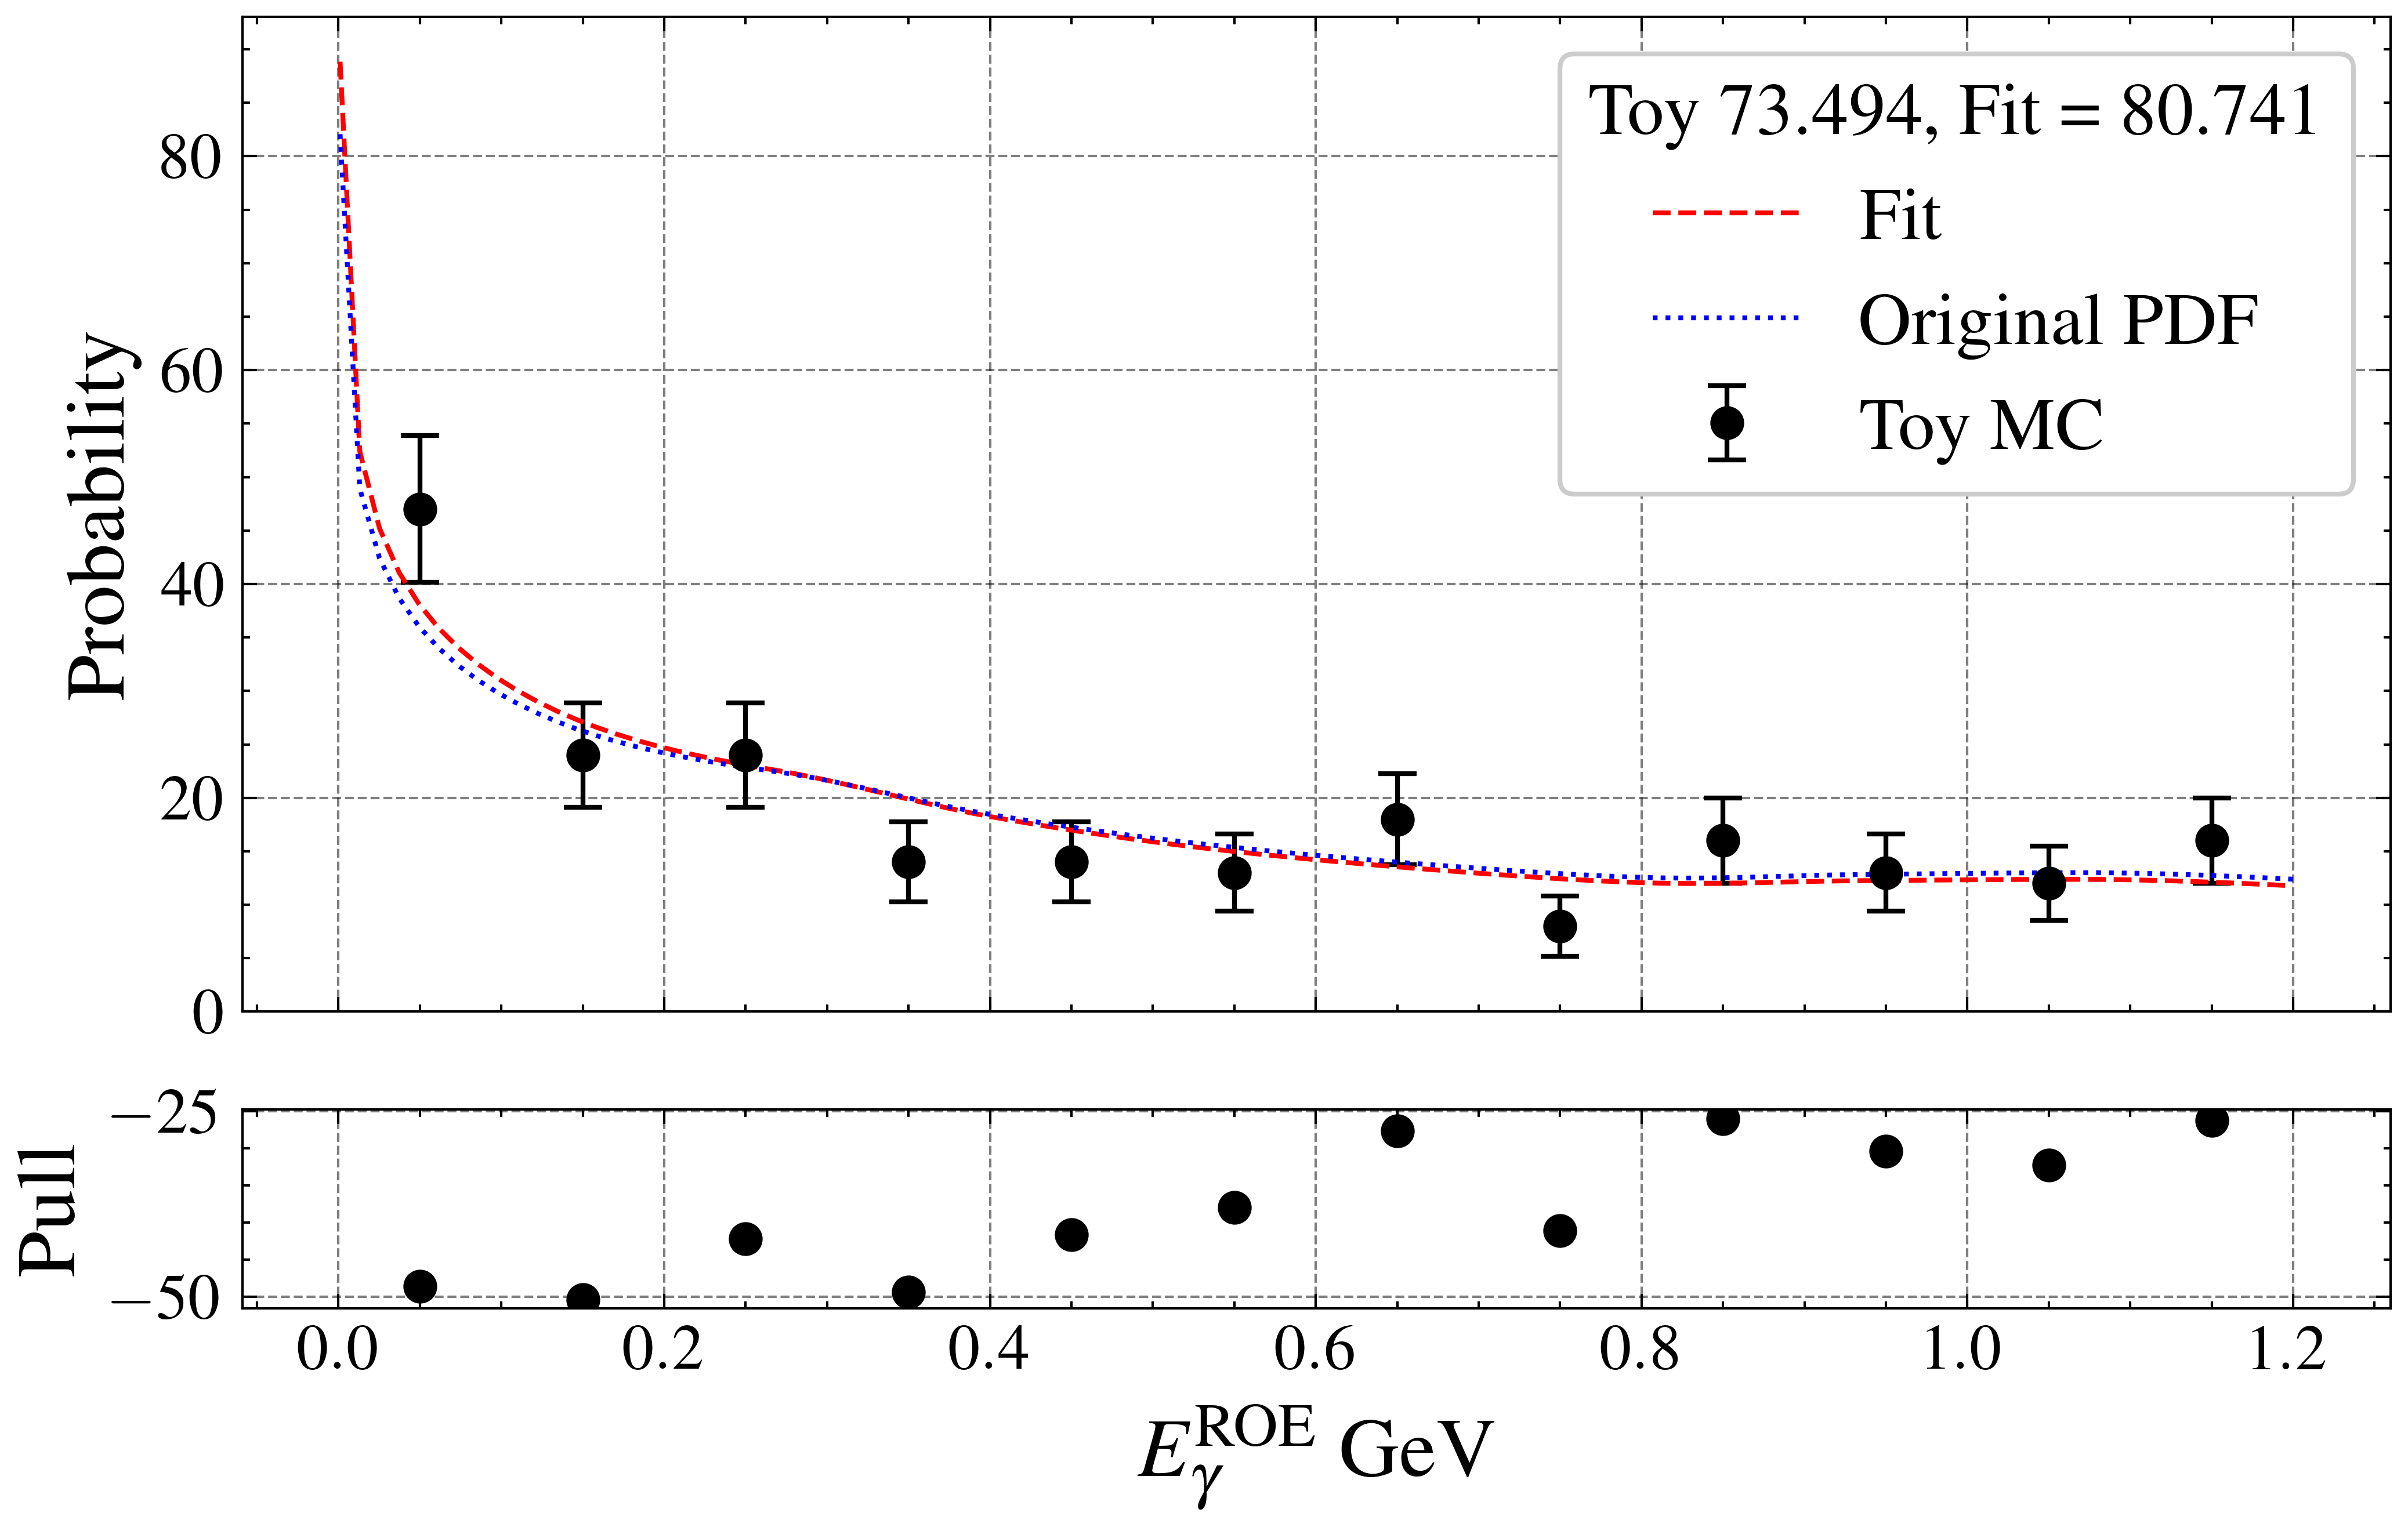

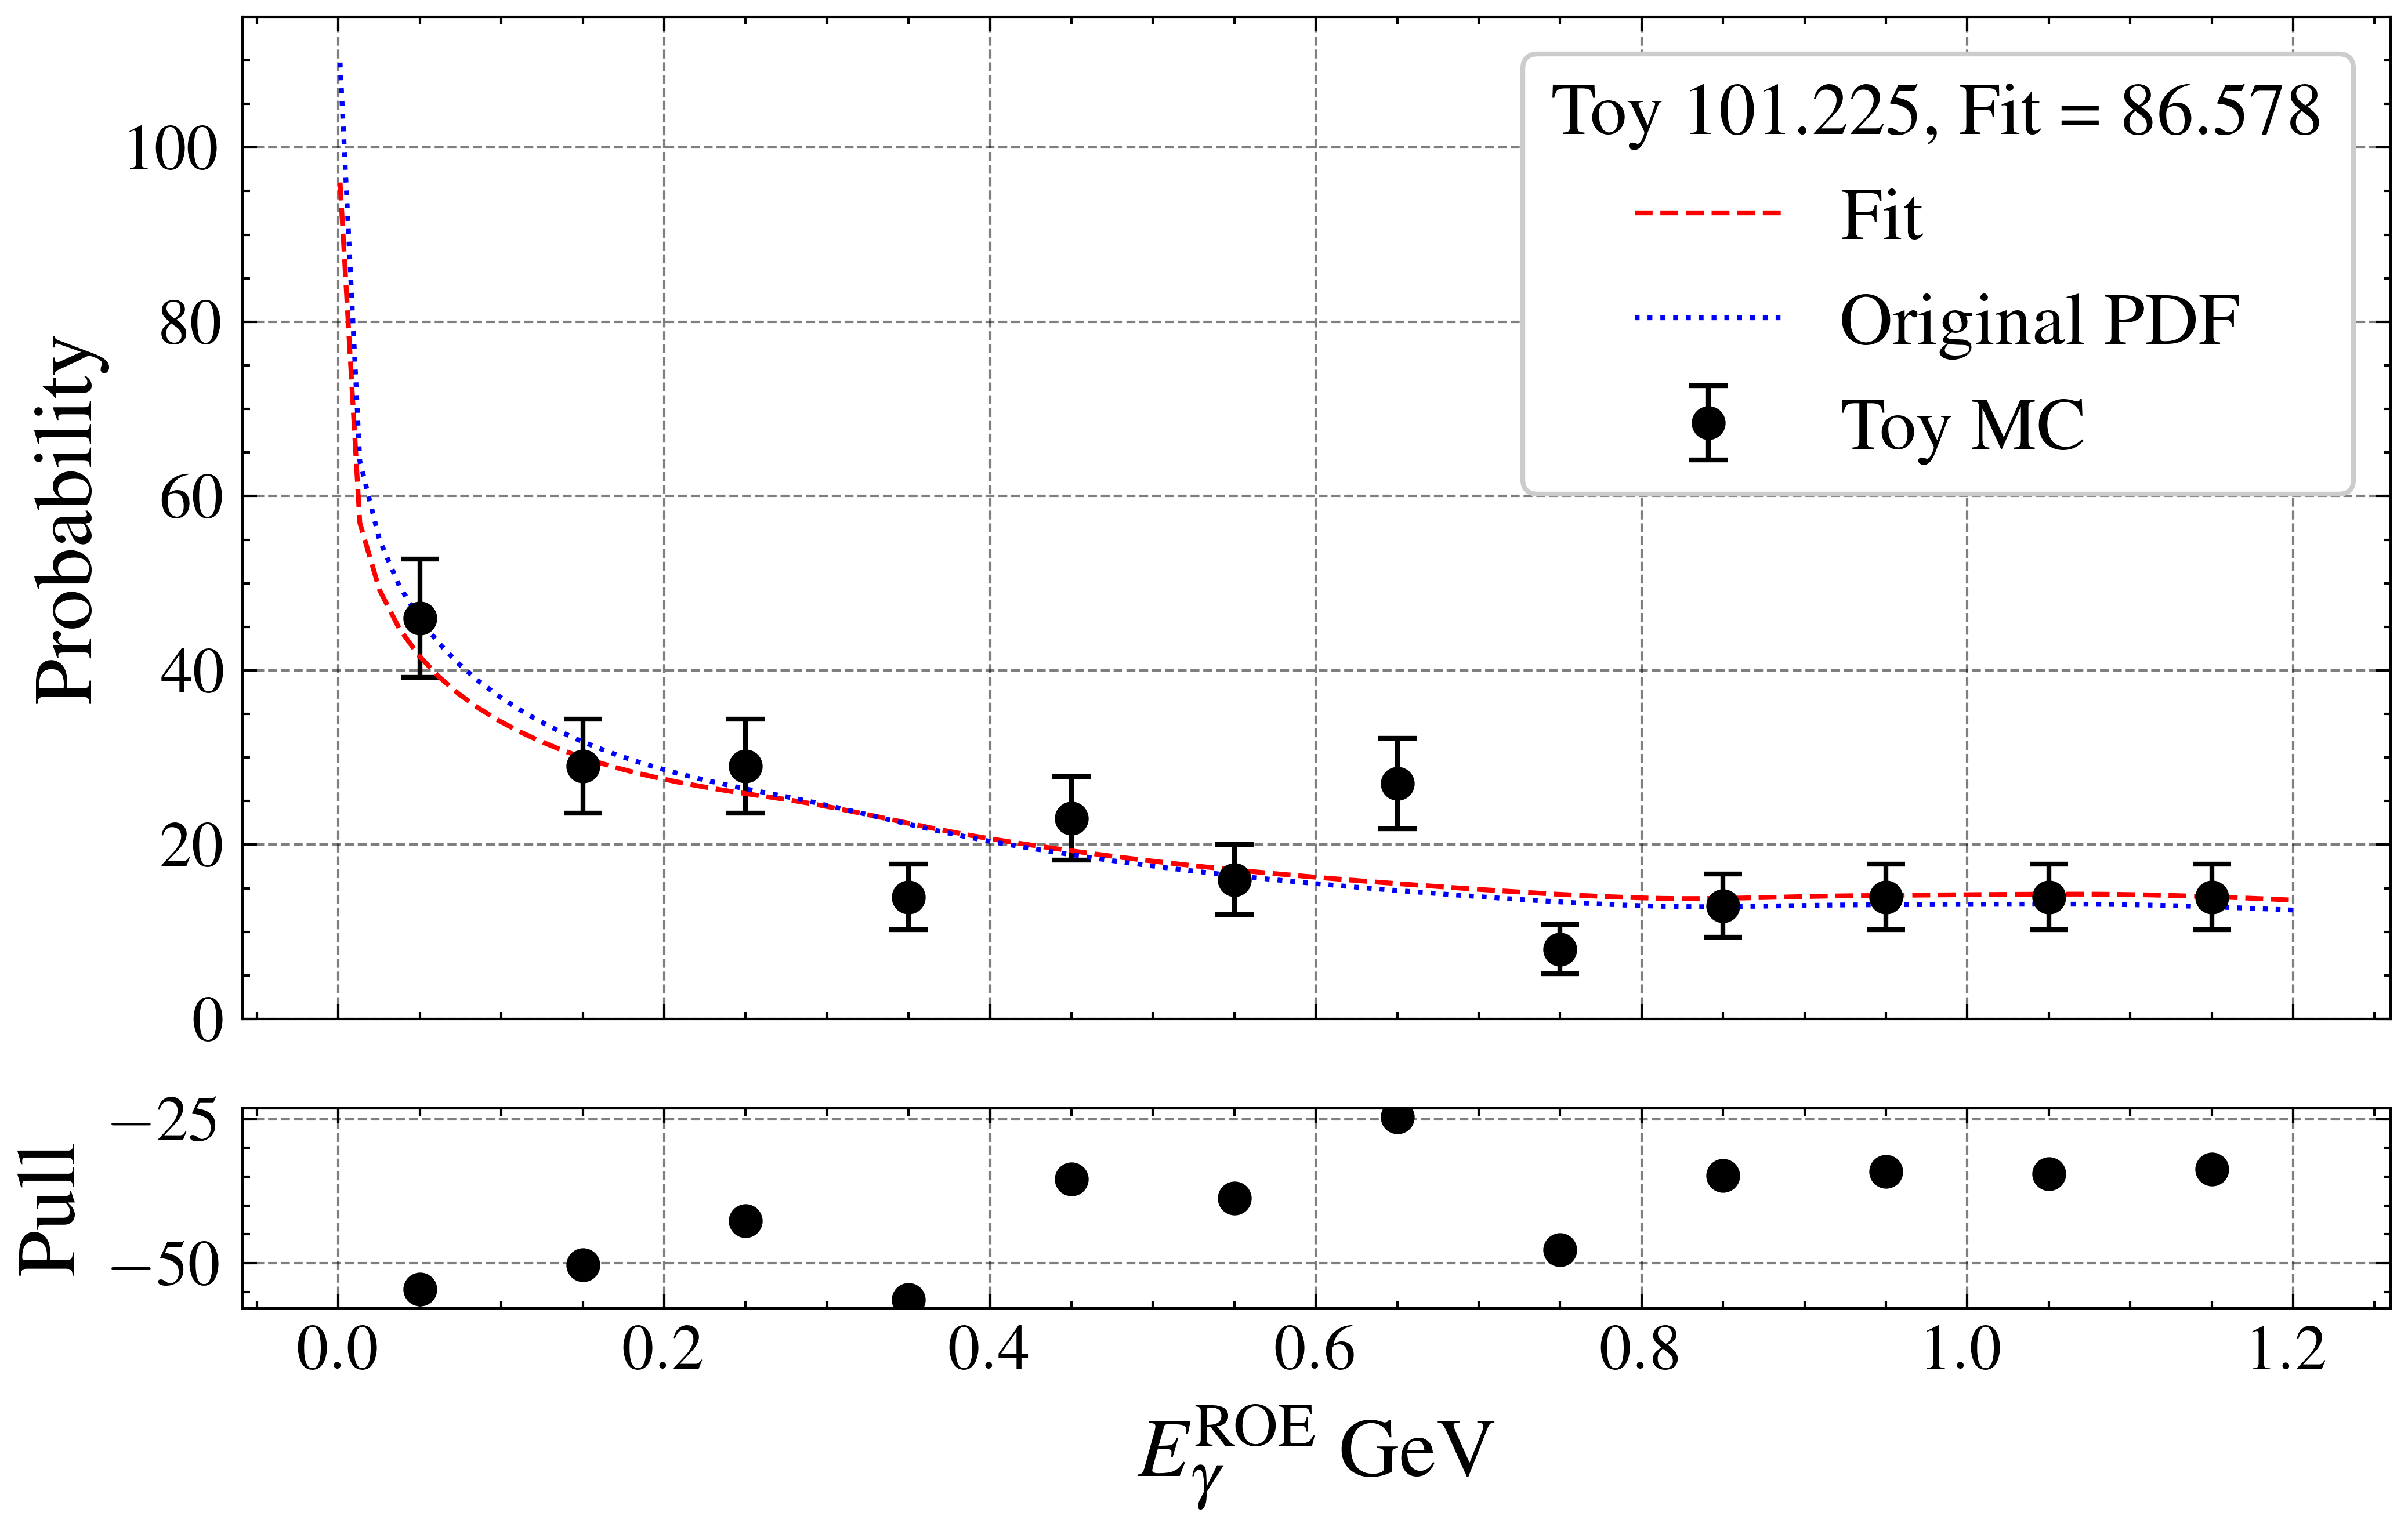

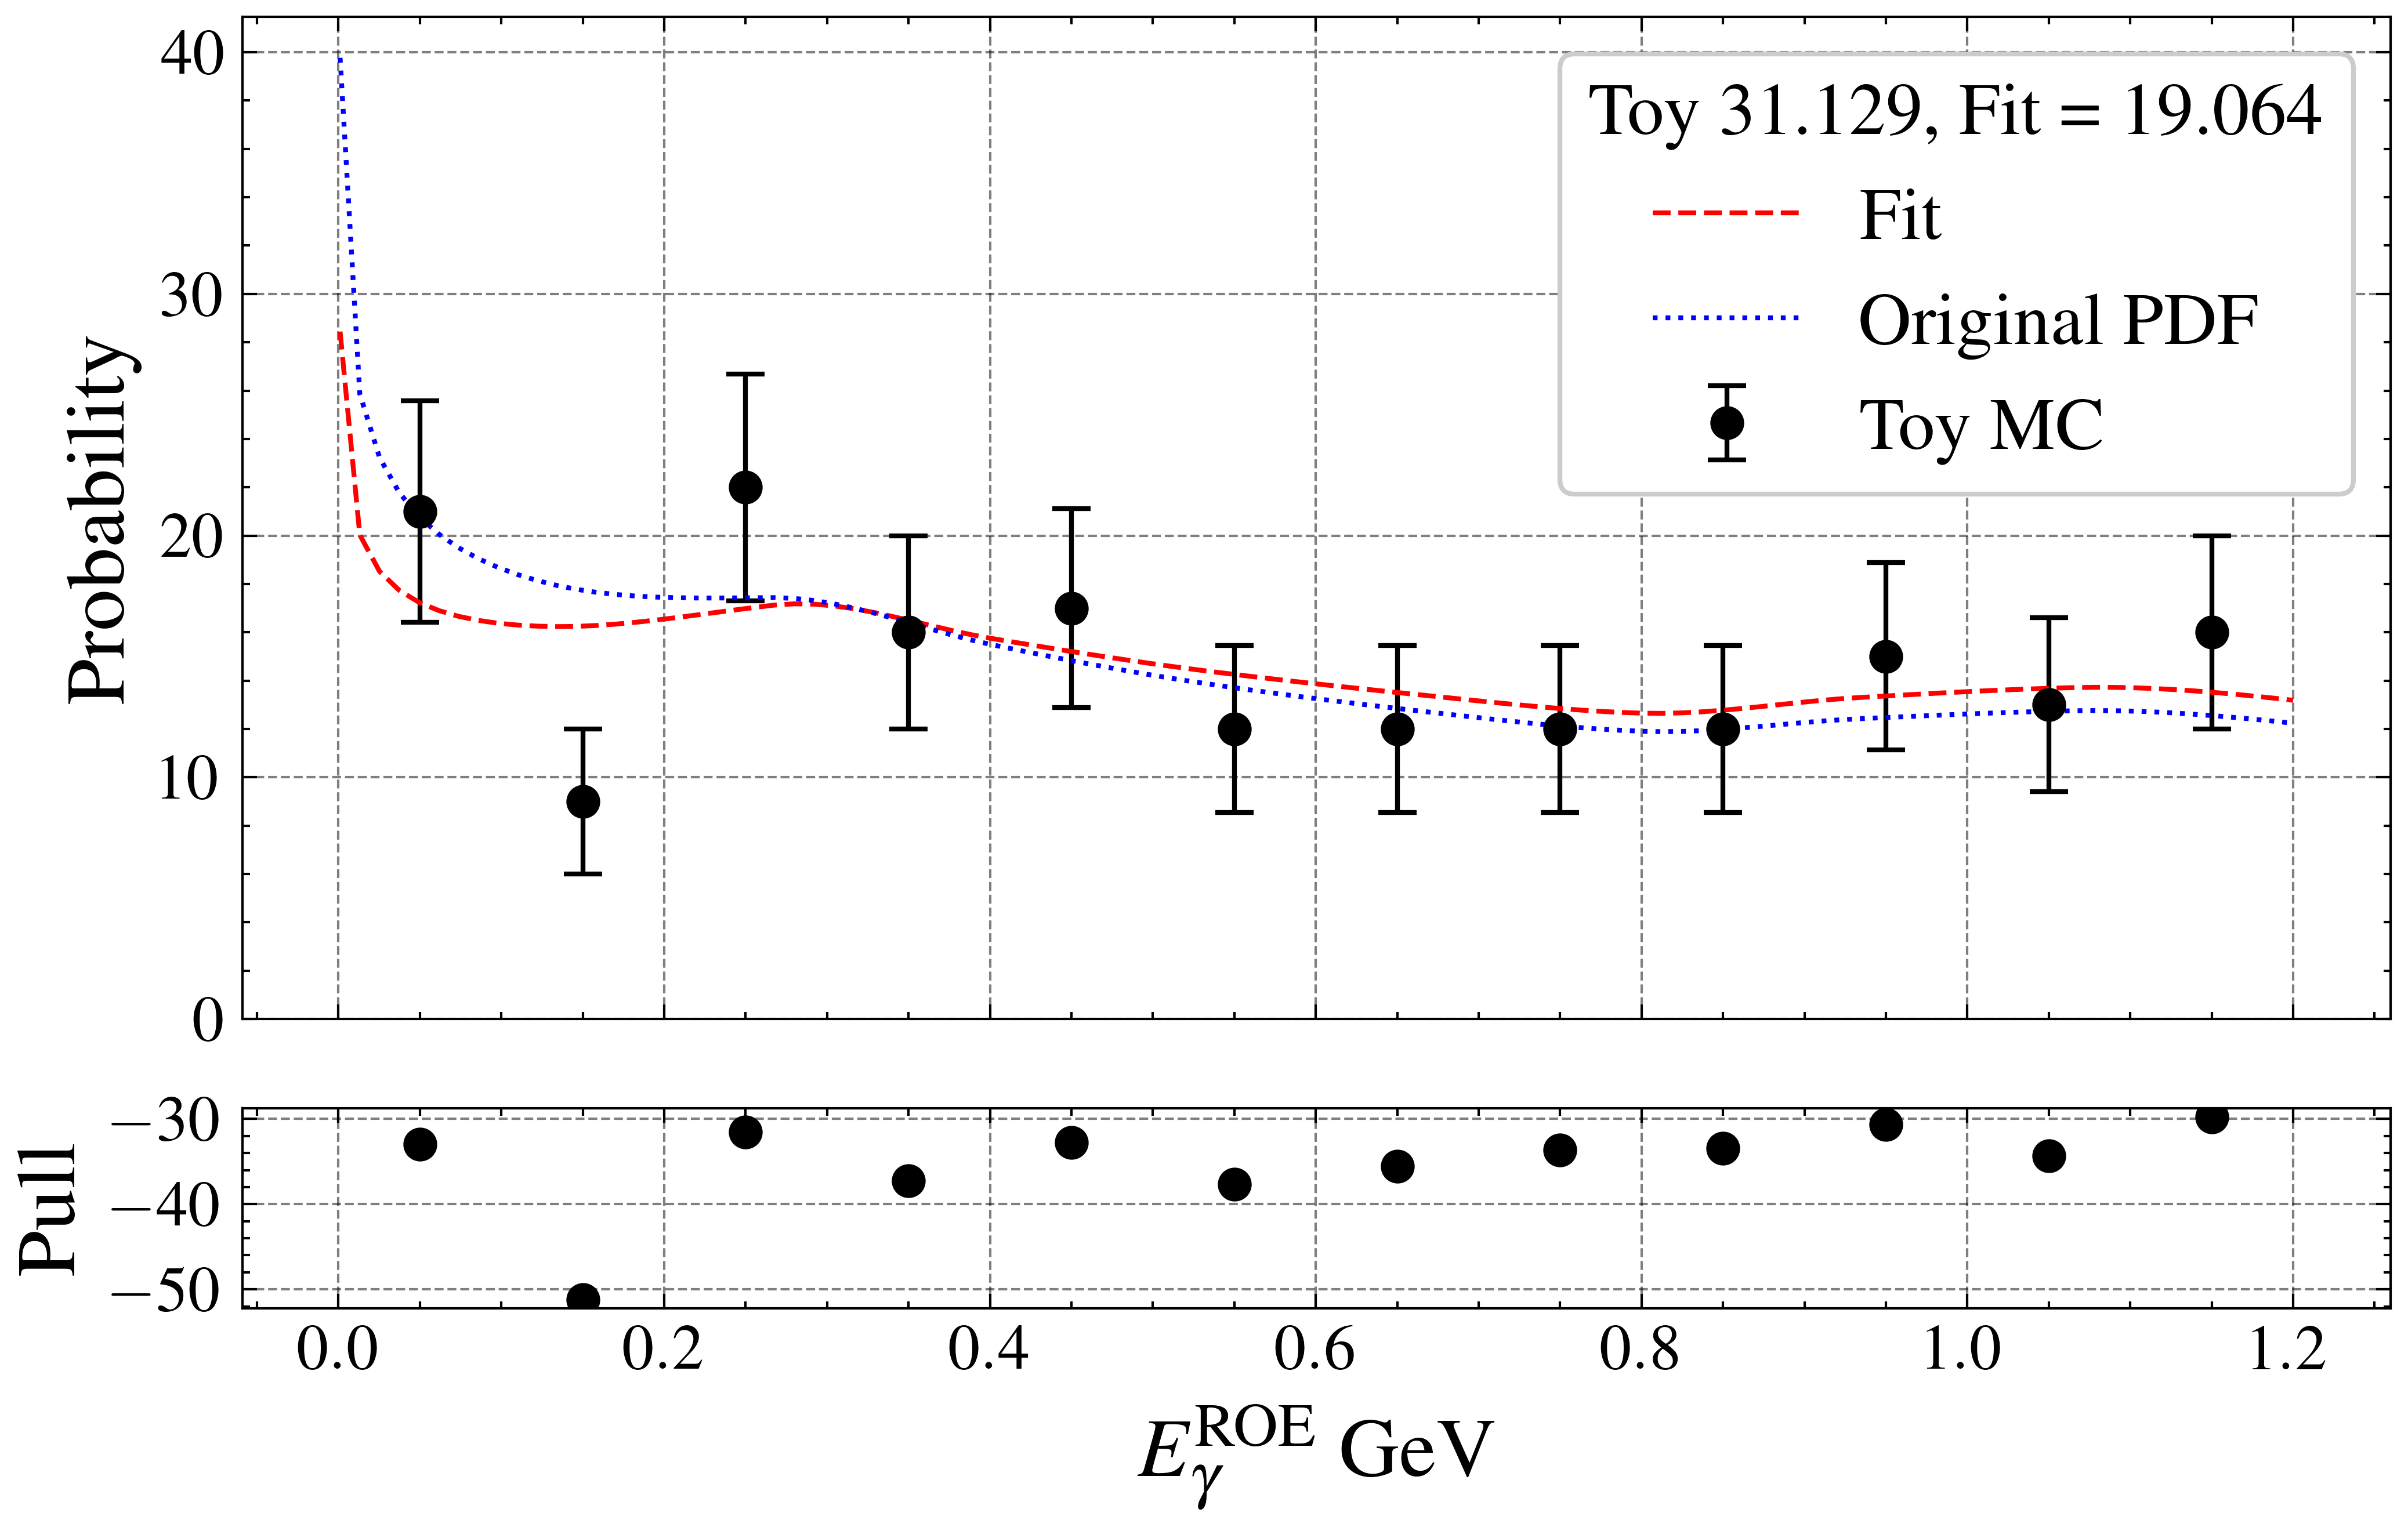

In [65]:

wbin = 0.1
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)//wbin + 2))

plt_s = (12/1.7, 6/1.7)
pull_s = (12/6, 6/6)

n_toys = 5; i = 0
fit_results = []
A_list = []
while i < n_toys:   
    A = np.random.uniform(0, 1)

    toy_sample = np.concat([gen_toy(dg_pdf, a, b, size=int(N_bg/6)), gen_toy(lambda x: f_E_g_lep_gamma(x, **rez0), a, b, size=int(N_bg/6*A))])

    rez = max_lik(
            f_fit,
            toy_sample,
            {"A": N_bg / 6, "B": N_bg / 6},
            a=a, b=b,
            bounds={"A": (0, N_bg), "B": (0, N_bg)}
        )    
    print(rez)
    i += 1
    A_list.append(A/(1+A))
    fit_results.append(rez["A"])

    fig, axs = plt.subplots(2, 1, figsize=(plt_s[0], plt_s[1]+pull_s[1]), gridspec_kw={'height_ratios': [1, 0.2]}, sharex=True)
    
    ax = axs[0]
    counts, bin_centers = errorhist(toy_sample, bins=bins, err_func=np.sqrt, fmt='o', capsize=4, label="Toy MC", axs = ax)
    ax.plot(np.linspace(0.001, b, 100), f_fit(np.linspace(0.001, b, 100), **rez)*wbin, label="Fit")
    ax.plot(np.linspace(0.001, b, 100), f_fit(np.linspace(0.001, b, 100), A = N_bg/6*A, B = N_bg/6)*wbin, label="Original PDF")
    ax.set_ylabel("Probability")
    ax.legend(title =f"Toy {N_bg/6*A:.3f}, Fit = {rez['A']:.3f}")
    ax.set_ylim(0)

    ax_resid = axs[1]
    residuals = counts - f_fit(bin_centers, **rez)
    ax_resid.plot(bin_centers, residuals / np.sqrt(counts), 'o')
    ax_resid.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
    ax_resid.set_ylabel('$\\mathrm{Pull}$')
    ax_resid.set_xlim(ax.get_xlim()) 

    plt.tight_layout()

In [ ]:

wbin = 0.1
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)//wbin + 2))

n_toys = 1000; i = 0
fit_results = []
A_list = []
while i < n_toys:   
    A = np.random.uniform(0, 1)

    toy_sample = np.concat([gen_toy(dg_pdf, a, b, size=N_bg/6), gen_toy(lambda x: f_E_g_lep_gamma(x, **rez0), a, b, size=int(N_bg/6*A))])

    rez = max_lik(f_fit, toy_sample, {"A" : 0.5,}, bounds={"A": (0, 1)})

    i += 1
    A_list.append(A/(1+A))
    fit_results.append(rez["A"])


C:\Users\matve\AppData\Local\Temp\ipykernel_16024\2932709250.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_fit = lambda x, *, A: f_E_g_lep_gamma(x, **rez0)/np.trapz(f_E_g_lep_gamma(np.linspace(0, 1.2, 1000), **rez0), np.linspace(0, 1.2, 1000)) * np.abs(A) + dg_pdf(x) * np.abs(1 - A)


In [ ]:
A_list = np.array(A_list)
fit_results = np.array(fit_results)

In [ ]:
errors = fit_results - A_list
mean = np.mean(errors)
error_std = np.std(errors, ddof=1)

print(f"Error: {mean:.4f} +/- {error_std:.4f}")

Error: -0.0012 +/- 0.0572
